<a href="https://colab.research.google.com/github/LeoLomardo/Inteligencia-Computacional-Aplicada/blob/main/Redes%20Neurais/Trabalho%202/Trabalho2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
colab = True 

import os 

if colab:
    !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
    os.chdir('/content/PUC_Redes_Neurais/grad/lista 2')

Cloning into 'PUC_Redes_Neurais'...
remote: Enumerating objects: 302, done.
remote: Counting objects: 100% (302/302), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 302 (delta 114), reused 233 (delta 45), pack-reused 0
Receiving objects: 100% (302/302), 3.98 MiB | 8.97 MiB/s, done.
Resolving deltas: 100% (114/114), done.


# PUC-Rio 
## Departamento de Engenharia Elétrica
## Trabalho 2 - Previsão de séries temporais

Estudante: Leo Land Bairos Lomardo

Base de dados: s_microclima5

##Bibliografia 
https://edisciplinas.usp.br/pluginfile.php/5352773/mod_resource/content/1/Previsao%20de%20Demanda%20reinaldo%2020031211%2020160301%2020170317%20%281%29.pdf

https://docs.ufpr.br/~thom/papers/dissertation.pdf

https://repositorio.ufc.br/bitstream/riufc/49168/3/2019_tcc_ismourao.pdf

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader 
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

from model_utils import train, train_multi_step_model

from tqdm.notebook import tqdm

#adicionei essa biblioteca para analisar sasonalidade dos dados
from statsmodels.tsa.seasonal import seasonal_decompose



## Preparação para a lista

In [ ]:
class CustomDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [ ]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation] sem ativacao na camada de saida, p nn limitar a previsao da serie de acordo com max e min anteriores
    self.out = nn.Sigmoid() #Para o caso binário

  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y


In [ ]:
def transform_data(data, lag = 1, test_split = 0.1, normalize = True, category = 'binary'):
    
    '''
    Função para transformação de dados para a 2ª Lista de exercícios.
    A transformação de dados nesta etapa tem duas funções principais: a transformação da série em uma forma tabular para 
    o aprendizado de Redes Neurais e normalização dos dados.
    Parâmetros de entrada:
    - data: base de dados a ser ajeitado.
    - test_split: propoporção da base de dados para teste. Caso seja um float entre 0 e 1, o valor é interpretado como proporção. 
    Caso seja um valor inteiro, é compreendido como o tempo reservado para generalização (e.g. lag = 12 reserva os 12 últimos 
    registros para o teste).
    - normalize: normalização da série. Default True
    - categ: string contendo a codificação a ser realizada para a variável exógena (no caso, o mês).

    A função retorna dois dataframes, sendo o primeiro para treinamento e o segundo para generalização.
    '''

    global _min
    global _max
    
    
    data_values = data.values
    
    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)
        
    elif test_split > 1 and type(test_split) is int:

        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)
        
    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')
    
    assert test_values.shape[0] >= (lag)
    
    _min = np.min(train_values)
    _max = np.max(train_values)
    
    if normalize:
        
        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)
        
    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))
    
    
    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))
    
    
    
    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]
        

    
    if category == 'binary':
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]
        
    elif category == '1toN':
        pass
    
    else:
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']
    
    
    new_data = np.hstack((t,new_data))
    
    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]
    
    
    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)] 
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)
    
    
    
    
    return new_train_df, new_test_df

In [ ]:
dataset_name = 'microclima5'
path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/s_{dataset_name}.csv'
raw_data = pd.read_csv(path)


## Parte I - Compreensão do problema

Total: 3,0 pts.

#### 1.	Visualize, em forma de gráfico, a dinâmica temporal da série escolhida. A série é adequada para a modelagem usando Redes Neurais? Caso não seja, que técnicas podem ser aplicadas para ajustar o comportamento da série?

Text(0, 0.5, 'value')

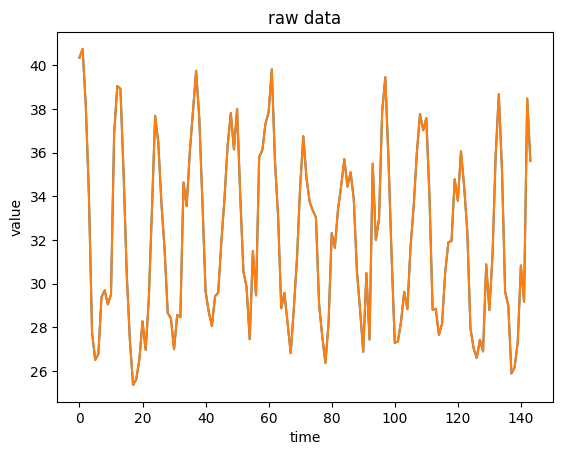

In [ ]:
#tabela inicial
raw_data
raw_data['value'].plot()
plt.plot(raw_data['value'])
plt.title('raw data')
plt.xlabel('time')
plt.ylabel('value')

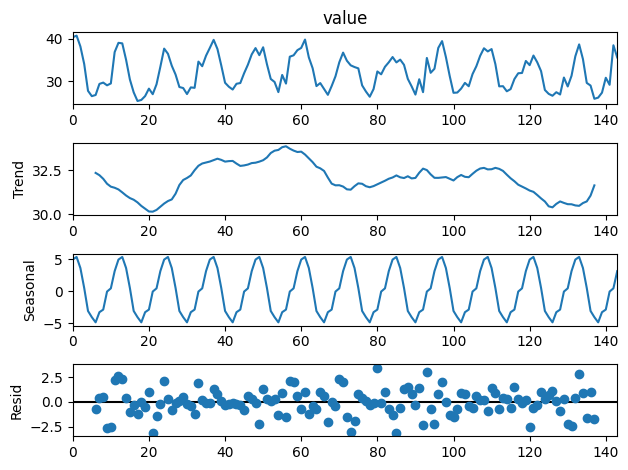

In [ ]:
#analise sasonalidade dados
resposta = seasonal_decompose(raw_data['value'], model='additive', period = 12).plot()


##### Rascunho Resposta
Não ta do jeito certo, precisa separar entre entrada e saidas, quebrar a tabela em mais colunas 
onde as entradas da rede seriam tempos anteriores
  t-1
  t-2   prever t+1
  t-3
  salvar variavel (mes) pq pode ajudar a rede a aprender sobre um mes sazonal ou coisa do tipo 

  Rede Neural nn é bom pra series temporais com tendencias (tando de alta qnt de queda ) pq ele fica limitado, ela n preve valores acima/abaixo dos valores q ela conhece
  Uma solucao p isso é diferenciar os valores ( trabalhar com a difereca da série), mitigando efeito de tendencia 


##### Resposta

Os dados apresentados informam a média mensal no período de 144 meses/ 12 anos, e esses valores são referentes a temperaturas, variável a apresenta uma sazonalidade ano após ano. Dessa forma, o algoritmos MLP pode ser aplicado nesse problema, visto que essa sazonalidade não gera problemas na modelagem da MLP, além de favorecer seu aprendizado e reconhecimento de padrões.


#### 2.	Nesta 2ª lista de exercícios, usaremos uma variável exógena que representa o mês de previsão (i.e. no instante t+1). De que forma esta variável pode auxiliar na previsão da série temporal?

Como podemos ver no gráfico, a série apresenta uma sazonalidade anual, logo, ao mostrarmos para a rede que em determinados intervalos de tempo, os valores apresentam uma média parecida, essa informação pode contribuir para o treinamento da rede.

#### 3. Observe que a base de dados não está em um formato adequado para o uso imediato de um modelo de Rede Neural para previsão de séries temporais. Descreva as etapas necessárias de transformação desta base de dados para que possamos utilizá-la no treinamento de uma MLP. Considere que os padrões de entrada (e saída) devem ser normalizados.

In [ ]:
# mes // t-3 // t-2 // t-1 // t. // t+1 = saída   
#importante definir horizonte de previsao 
#como a tabela tem informações de 144 meses(12 anos), vamos usar 11 anos para prever o seguinte, q no caso sao os 12 meses seguintes 


## Parte 2 - Previsão one-step

Total: 2,0 pts

<b> IMPORTANTE! </b> Este processo não é a previsão multi-step, conforme ensinado em sala de aula. 
Esta parte da lista é importante para evitar erros de avaliação para a previsão de séries temporais com um horizonte de previsão maior que 1.

#### 1.	Execute o script para a previsão one-step. Avalie o resultado (conjunto de treinamento e teste) usando métricas apropriadas, como RMSE e MAE.

In [ ]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=10,test_split = prev,normalize=True,category='binary')
#lag == quantos passos anteriores(meses) vou usar p prever o futuro, nn usar mais q 10

train_val


,month_0,month_1,month_2,month_3,y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,1.0,1.0,0.0,0.0,0.974223,1.000000,0.834154,0.565910,0.155624,0.074180,0.091969,0.261582,0.281446,0.239795,0.268619,0.747902
1,0.0,0.0,0.0,1.0,1.000000,0.834154,0.565910,0.155624,0.074180,0.091969,0.261582,0.281446,0.239795,0.268619,0.747902,0.889484
2,0.0,0.0,1.0,0.0,0.834154,0.565910,0.155624,0.074180,0.091969,0.261582,0.281446,0.239795,0.268619,0.747902,0.889484,0.881214
3,0.0,0.0,1.0,1.0,0.565910,0.155624,0.074180,0.091969,0.261582,0.281446,0.239795,0.268619,0.747902,0.889484,0.881214,0.630534
4,0.0,1.0,0.0,0.0,0.155624,0.074180,0.091969,0.261582,0.281446,0.239795,0.268619,0.747902,0.889484,0.881214,0.630534,0.329522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,1.0,0.0,0.0,0.0,0.335773,0.424383,0.428598,0.612235,0.548130,0.695331,0.591421,0.456497,0.168592,0.109382,0.080244,0.134481
117,1.0,0.0,0.0,1.0,0.424383,0.428598,0.612235,0.548130,0.695331,0.591421,0.456497,0.168592,0.109382,0.080244,0.134481,0.099773
118,1.0,0.0,1.0,0.0,0.428598,0.612235,0.548130,0.695331,0.591421,0.456497,0.168592,0.109382,0.080244,0.134481,0.099773,0.358750
119,1.0,0.0,1.0,1.0,0.612235,0.548130,0.695331,0.591421,0.456497,0.168592,0.109382,0.080244,0.134481,0.099773,0.358750,0.222369


In [ ]:
test_val


,month_0,month_1,month_2,month_3,y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,1.0,0.695331,0.591421,0.456497,0.168592,0.109382,0.080244,0.134481,0.099773,0.358750,0.222369,0.385629,0.684366
1,0.0,0.0,1.0,0.0,0.591421,0.456497,0.168592,0.109382,0.080244,0.134481,0.099773,0.358750,0.222369,0.385629,0.684366,0.865464
2,0.0,0.0,1.0,1.0,0.456497,0.168592,0.109382,0.080244,0.134481,0.099773,0.358750,0.222369,0.385629,0.684366,0.865464,0.640042
3,0.0,1.0,0.0,0.0,0.168592,0.109382,0.080244,0.134481,0.099773,0.358750,0.222369,0.385629,0.684366,0.865464,0.640042,0.276696
4,0.0,1.0,0.0,1.0,0.109382,0.080244,0.134481,0.099773,0.358750,0.222369,0.385629,0.684366,0.865464,0.640042,0.276696,0.236051
5,0.0,1.0,1.0,0.0,0.080244,0.134481,0.099773,0.358750,0.222369,0.385629,0.684366,0.865464,0.640042,0.276696,0.236051,0.033918
6,0.0,1.0,1.0,1.0,0.134481,0.099773,0.358750,0.222369,0.385629,0.684366,0.865464,0.640042,0.276696,0.236051,0.033918,0.051778
7,1.0,0.0,0.0,0.0,0.099773,0.358750,0.222369,0.385629,0.684366,0.865464,0.640042,0.276696,0.236051,0.033918,0.051778,0.127562
8,1.0,0.0,0.0,1.0,0.358750,0.222369,0.385629,0.684366,0.865464,0.640042,0.276696,0.236051,0.033918,0.051778,0.127562,0.355425
9,1.0,0.0,1.0,0.0,0.222369,0.385629,0.684366,0.865464,0.640042,0.276696,0.236051,0.033918,0.051778,0.127562,0.355425,0.247731


In [ ]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [ ]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [ ]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [ ]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = 20, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

  8%|▊         | 78/1000 [00:02<00:13, 70.50it/s]

Epoch 51/1000, Loss: 0.0420


 11%|█         | 107/1000 [00:02<00:15, 58.22it/s]

Epoch 101/1000, Loss: 0.0256


 16%|█▋        | 165/1000 [00:03<00:11, 75.75it/s]

Epoch 151/1000, Loss: 0.0155


 21%|██        | 209/1000 [00:03<00:08, 96.49it/s]

Epoch 201/1000, Loss: 0.0122


 27%|██▋       | 274/1000 [00:04<00:06, 116.66it/s]

Epoch 251/1000, Loss: 0.0114


 31%|███       | 306/1000 [00:04<00:05, 118.73it/s]

Epoch 301/1000, Loss: 0.0110


 38%|███▊      | 376/1000 [00:05<00:03, 161.50it/s]

Epoch 351/1000, Loss: 0.0107


 43%|████▎     | 430/1000 [00:05<00:03, 172.79it/s]

Epoch 401/1000, Loss: 0.0105


 48%|████▊     | 483/1000 [00:05<00:03, 166.14it/s]

Epoch 451/1000, Loss: 0.0103


 52%|█████▏    | 520/1000 [00:05<00:02, 166.57it/s]

Epoch 501/1000, Loss: 0.0101


 58%|█████▊    | 576/1000 [00:06<00:02, 170.14it/s]

Epoch 551/1000, Loss: 0.0100


 61%|██████    | 611/1000 [00:06<00:02, 139.84it/s]

Epoch 601/1000, Loss: 0.0098


 68%|██████▊   | 683/1000 [00:07<00:01, 169.19it/s]

Epoch 651/1000, Loss: 0.0097


 72%|███████▏  | 718/1000 [00:07<00:01, 159.82it/s]

Epoch 701/1000, Loss: 0.0096


 78%|███████▊  | 776/1000 [00:07<00:01, 177.64it/s]

Epoch 751/1000, Loss: 0.0095


 81%|████████  | 810/1000 [00:07<00:01, 138.70it/s]

Epoch 801/1000, Loss: 0.0094


 87%|████████▋ | 868/1000 [00:08<00:00, 169.52it/s]

Epoch 851/1000, Loss: 0.0094


 92%|█████████▏| 920/1000 [00:08<00:00, 141.21it/s]

Epoch 901/1000, Loss: 0.0093


 97%|█████████▋| 974/1000 [00:08<00:00, 153.07it/s]

Epoch 951/1000, Loss: 0.0092


100%|██████████| 1000/1000 [00:09<00:00, 109.19it/s]

Epoch 1001/1000, Loss: 0.0092


In [ ]:
y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()


Erro MSE = 7.53 
Erro MAE = 1.991


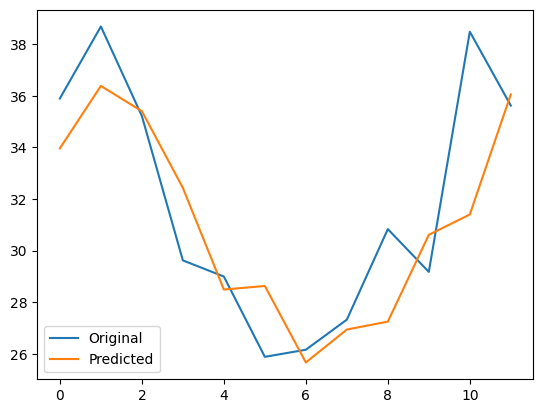

In [ ]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min

mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')


#erro medio quadrado e erro medio absoluto


Resultados

##### Mundaca Func p/ parte II

In [ ]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation] sem ativacao na camada de saida, p nn limitar a previsao da serie de acordo com max e min anteriores
    #self.out = nn.Sigmoid() #Para o caso binário

  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

#### 2.	Modifique a técnica de codificação mensal de ‘binário’ para ‘numérico’. Qual a mudança existente na arquitetura da Rede Neural? Analise o resultado (conjunto de treinamento e teste), usando as métricas adequadas.

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 20
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

  6%|▋         | 63/1000 [00:00<00:08, 104.73it/s]

Epoch 51/1000, Loss: 0.0340


 12%|█▏        | 122/1000 [00:00<00:06, 136.59it/s]

Epoch 101/1000, Loss: 0.0204


 17%|█▋        | 171/1000 [00:01<00:05, 149.85it/s]

Epoch 151/1000, Loss: 0.0154


 23%|██▎       | 233/1000 [00:01<00:04, 183.13it/s]

Epoch 201/1000, Loss: 0.0143


 27%|██▋       | 271/1000 [00:01<00:04, 149.74it/s]

Epoch 251/1000, Loss: 0.0139


 32%|███▎      | 325/1000 [00:02<00:04, 147.52it/s]

Epoch 301/1000, Loss: 0.0137


 38%|███▊      | 378/1000 [00:02<00:03, 159.46it/s]

Epoch 351/1000, Loss: 0.0134


 41%|████      | 410/1000 [00:02<00:04, 138.81it/s]

Epoch 401/1000, Loss: 0.0132


 47%|████▋     | 467/1000 [00:03<00:04, 124.09it/s]

Epoch 451/1000, Loss: 0.0130


 51%|█████     | 508/1000 [00:03<00:04, 115.12it/s]

Epoch 501/1000, Loss: 0.0128


 56%|█████▌    | 556/1000 [00:04<00:06, 63.79it/s]

Epoch 551/1000, Loss: 0.0127


 60%|██████    | 603/1000 [00:05<00:07, 49.91it/s]

Epoch 601/1000, Loss: 0.0125


 66%|██████▌   | 656/1000 [00:06<00:06, 51.84it/s]

Epoch 651/1000, Loss: 0.0124


 72%|███████▏  | 723/1000 [00:07<00:02, 113.85it/s]

Epoch 701/1000, Loss: 0.0122


 78%|███████▊  | 777/1000 [00:07<00:01, 155.26it/s]

Epoch 751/1000, Loss: 0.0121


 83%|████████▎ | 834/1000 [00:08<00:00, 174.05it/s]

Epoch 801/1000, Loss: 0.0120


 87%|████████▋ | 870/1000 [00:08<00:00, 170.03it/s]

Epoch 851/1000, Loss: 0.0119


 91%|█████████ | 912/1000 [00:08<00:00, 186.00it/s]

Epoch 901/1000, Loss: 0.0118


 99%|█████████▉| 989/1000 [00:09<00:00, 174.25it/s]

Epoch 951/1000, Loss: 0.0117


100%|██████████| 1000/1000 [00:09<00:00, 110.18it/s]


Epoch 1001/1000, Loss: 0.0116
Erro MSE = 7.118 
Erro MAE = 1.819


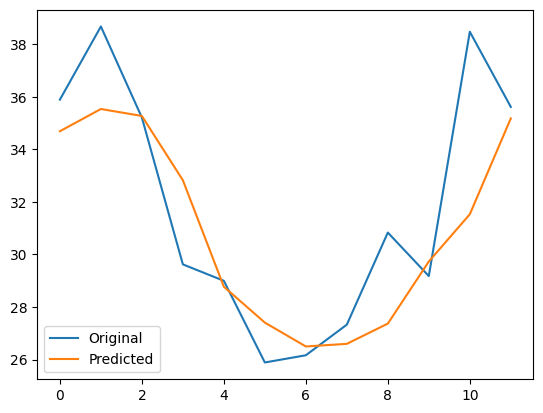

In [ ]:

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs , device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

#####Resposta

Executei diversos testes, procurando analisar a aleatoriedade da rede e ver se faria grande diferença nos resultados a codificação ser binária ou numérica, e eu achei que a condificação numérica apresentou resultados levemente melhores. Analisando a função "transform_data" a procura de uma explicação para esses resultados, entendi que a codificação numérica implica em apenas 1 entrada para cada mês da rede, já na binária esse valor sobe para 4, mexendo no número de pesos da rede.

## Parte 3 - Previsão multi-step

Total: 5,0 pts.

#### 1.	Esquematize como você implementaria o processo de previsão multi-step. Descreva todos os passos necessários, e em seguida compare com o código fornecido para a previsão. 

In [ ]:
def multi_step(model, X_test, cod='numeric'):
  y_result = []
  X_t = np.copy(X_test[0])
  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())
      
      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12
        
        #Alterando a variável mês
        X_t[0] = tmp/12
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        pass

      else:
        print('Erro de codificação.')
        break
      

      X_t[-1] = y_hat
      
      y_result.append(y_hat[0].detach().numpy())


  return np.array(y_result)

#####Resposta
Como o processo multi-step consiste em, inserir dados previstos pela rede na retroalimentação da própria rede. No nosso caso, onde a base de dados está organizada de maneira mensal, esse processo nos permite prever o mês t+2, utilizando como base de treinamento o mês t+1, que foi fruto de uma previsão da rede.

#### 2.	Faça a previsão multi-step para o horizonte de previsão igual a 12. Perceba que o resultado da métrica é, geralmente, pior do que o apresentado para a previsão one-step. Por quê? É justo comparar o resultado deste item com o que foi apresentado anteriormente? Discuta. 

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 20
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')
#mudar o lag = 12 


  8%|▊         | 82/1000 [00:00<00:05, 173.70it/s]

Epoch 51/1000, Loss: 0.0415


 12%|█▏        | 121/1000 [00:00<00:04, 176.55it/s]

Epoch 101/1000, Loss: 0.0253


 17%|█▋        | 171/1000 [00:01<00:05, 150.94it/s]

Epoch 151/1000, Loss: 0.0169


 22%|██▏       | 224/1000 [00:01<00:05, 146.15it/s]

Epoch 201/1000, Loss: 0.0146
Epoch 251/1000, Loss: 0.0142


 35%|███▍      | 348/1000 [00:01<00:02, 264.27it/s]

Epoch 301/1000, Loss: 0.0140
Epoch 351/1000, Loss: 0.0138


 44%|████▍     | 445/1000 [00:02<00:01, 300.96it/s]

Epoch 401/1000, Loss: 0.0136
Epoch 451/1000, Loss: 0.0134


 54%|█████▍    | 541/1000 [00:02<00:01, 312.03it/s]

Epoch 501/1000, Loss: 0.0132
Epoch 551/1000, Loss: 0.0130


 64%|██████▎   | 637/1000 [00:02<00:01, 305.64it/s]

Epoch 601/1000, Loss: 0.0128
Epoch 651/1000, Loss: 0.0127


 73%|███████▎  | 734/1000 [00:03<00:00, 314.80it/s]

Epoch 701/1000, Loss: 0.0125
Epoch 751/1000, Loss: 0.0124


 83%|████████▎ | 832/1000 [00:03<00:00, 316.23it/s]

Epoch 801/1000, Loss: 0.0123
Epoch 851/1000, Loss: 0.0122


 93%|█████████▎| 929/1000 [00:03<00:00, 308.71it/s]

Epoch 901/1000, Loss: 0.0121
Epoch 951/1000, Loss: 0.0120


100%|██████████| 1000/1000 [00:03<00:00, 252.19it/s]

Epoch 1001/1000, Loss: 0.0119


Erro MSE = 9.724 
Erro MAE = 2.322


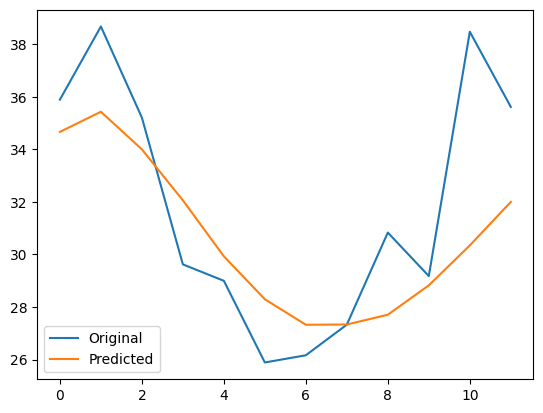

In [ ]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### Resposta
Como na previsão multi-step, a rede utiliza dados previstos por ela mesma para aprender, ocorre um aumento da taxa de erro, tanto MSE, quanto MAE. Tal erro intrínseco do algoritmo, gera um resultado pior ainda quando a base de dados é "pequena". Caso a base de dados fosse maior, esse erro  provavelmente seria menor.  

#### 3.	Modifique o tamanho da janela de entrada do modelo. Analise os resultados, utilizando as métricas adequadas. 

##### lag = 1

  8%|▊         | 81/1000 [00:00<00:03, 257.87it/s]

Epoch 51/1000, Loss: 0.0054
Epoch 101/1000, Loss: 0.0057


 19%|█▊        | 187/1000 [00:00<00:03, 253.15it/s]

Epoch 151/1000, Loss: 0.0063
Epoch 201/1000, Loss: 0.0069


 29%|██▉       | 294/1000 [00:01<00:02, 263.75it/s]

Epoch 251/1000, Loss: 0.0074
Epoch 301/1000, Loss: 0.0079


 40%|████      | 402/1000 [00:01<00:02, 256.84it/s]

Epoch 351/1000, Loss: 0.0085
Epoch 401/1000, Loss: 0.0091


 48%|████▊     | 482/1000 [00:01<00:02, 255.16it/s]

Epoch 451/1000, Loss: 0.0099
Epoch 501/1000, Loss: 0.0107


 59%|█████▉    | 591/1000 [00:02<00:01, 261.22it/s]

Epoch 551/1000, Loss: 0.0115


 64%|██████▍   | 644/1000 [00:02<00:01, 247.93it/s]

Epoch 601/1000, Loss: 0.0123


 70%|██████▉   | 695/1000 [00:02<00:01, 246.18it/s]

Epoch 651/1000, Loss: 0.0132
Epoch 701/1000, Loss: 0.0140


 80%|████████  | 801/1000 [00:03<00:00, 257.27it/s]

Epoch 751/1000, Loss: 0.0148
Epoch 801/1000, Loss: 0.0155


 88%|████████▊ | 877/1000 [00:03<00:00, 214.59it/s]

Epoch 851/1000, Loss: 0.0162


 92%|█████████▏| 920/1000 [00:03<00:00, 191.24it/s]

Epoch 901/1000, Loss: 0.0168


 98%|█████████▊| 978/1000 [00:04<00:00, 183.79it/s]

Epoch 951/1000, Loss: 0.0174


100%|██████████| 1000/1000 [00:04<00:00, 236.70it/s]


Epoch 1001/1000, Loss: 0.0179
Erro MSE = 22.316 
Erro MAE = 3.712


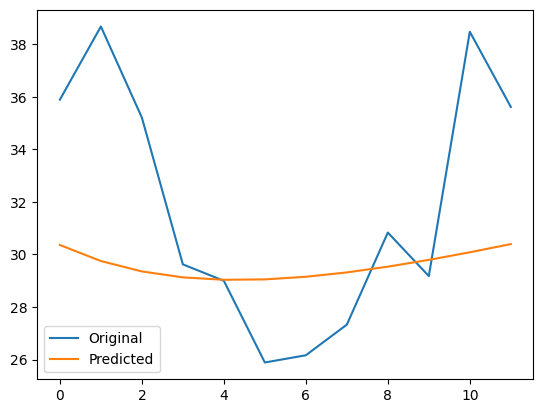

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 20
batch_size = 32
lag=1

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### lag = 2


  8%|▊         | 77/1000 [00:00<00:04, 186.44it/s]

Epoch 51/1000, Loss: 0.0000


 13%|█▎        | 134/1000 [00:00<00:04, 181.13it/s]

Epoch 101/1000, Loss: 0.0013


 17%|█▋        | 172/1000 [00:00<00:04, 178.81it/s]

Epoch 151/1000, Loss: 0.0025


 23%|██▎       | 227/1000 [00:01<00:04, 179.43it/s]

Epoch 201/1000, Loss: 0.0026


 29%|██▉       | 294/1000 [00:01<00:03, 207.39it/s]

Epoch 251/1000, Loss: 0.0020


 35%|███▍      | 347/1000 [00:01<00:02, 234.08it/s]

Epoch 301/1000, Loss: 0.0013
Epoch 351/1000, Loss: 0.0007


 45%|████▌     | 451/1000 [00:02<00:02, 250.24it/s]

Epoch 401/1000, Loss: 0.0004
Epoch 451/1000, Loss: 0.0002


 53%|█████▎    | 532/1000 [00:02<00:01, 260.65it/s]

Epoch 501/1000, Loss: 0.0001
Epoch 551/1000, Loss: 0.0000


 64%|██████▍   | 639/1000 [00:02<00:01, 258.45it/s]

Epoch 601/1000, Loss: 0.0000
Epoch 651/1000, Loss: 0.0000


 75%|███████▍  | 746/1000 [00:03<00:00, 257.22it/s]

Epoch 701/1000, Loss: 0.0000
Epoch 751/1000, Loss: 0.0000


 85%|████████▌ | 853/1000 [00:03<00:00, 262.00it/s]

Epoch 801/1000, Loss: 0.0000
Epoch 851/1000, Loss: 0.0000


 93%|█████████▎| 934/1000 [00:04<00:00, 263.07it/s]

Epoch 901/1000, Loss: 0.0000
Epoch 951/1000, Loss: 0.0000


100%|██████████| 1000/1000 [00:04<00:00, 231.57it/s]


Epoch 1001/1000, Loss: 0.0000
Erro MSE = 20.297 
Erro MAE = 4.037


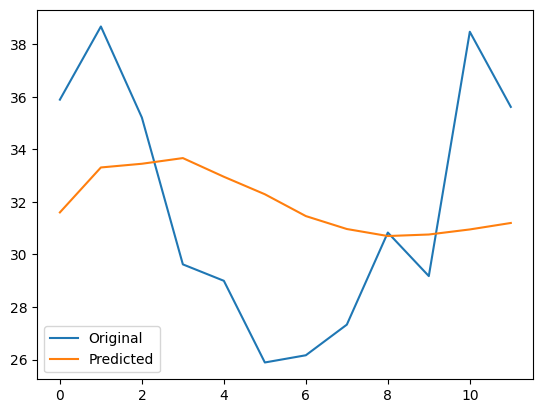

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 20
batch_size = 32
lag=2

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### lag = 3

 10%|▉         | 96/1000 [00:00<00:03, 287.76it/s]

Epoch 51/1000, Loss: 0.0500
Epoch 101/1000, Loss: 0.0397


 19%|█▉        | 190/1000 [00:00<00:02, 295.82it/s]

Epoch 151/1000, Loss: 0.0311
Epoch 201/1000, Loss: 0.0245


 29%|██▊       | 287/1000 [00:00<00:02, 304.13it/s]

Epoch 251/1000, Loss: 0.0197
Epoch 301/1000, Loss: 0.0167


 41%|████      | 412/1000 [00:01<00:01, 303.44it/s]

Epoch 351/1000, Loss: 0.0150
Epoch 401/1000, Loss: 0.0140


 51%|█████     | 507/1000 [00:01<00:01, 306.26it/s]

Epoch 451/1000, Loss: 0.0134
Epoch 501/1000, Loss: 0.0130


 60%|██████    | 600/1000 [00:01<00:01, 298.31it/s]

Epoch 551/1000, Loss: 0.0128
Epoch 601/1000, Loss: 0.0126


 70%|██████▉   | 697/1000 [00:02<00:00, 311.44it/s]

Epoch 651/1000, Loss: 0.0125
Epoch 701/1000, Loss: 0.0124


 79%|███████▉  | 794/1000 [00:02<00:00, 316.33it/s]

Epoch 751/1000, Loss: 0.0123
Epoch 801/1000, Loss: 0.0122


 89%|████████▉ | 891/1000 [00:02<00:00, 314.39it/s]

Epoch 851/1000, Loss: 0.0122
Epoch 901/1000, Loss: 0.0121


100%|██████████| 1000/1000 [00:03<00:00, 304.87it/s]

Epoch 951/1000, Loss: 0.0121
Epoch 1001/1000, Loss: 0.0120
Erro MSE = 18.425 
Erro MAE = 3.677


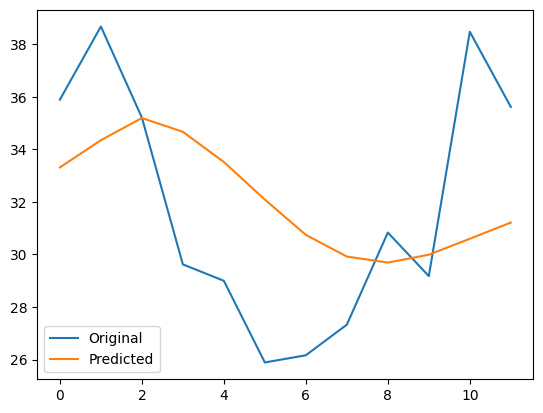

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 20
batch_size = 32
lag=3

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### lag = 4

  9%|▉         | 94/1000 [00:00<00:02, 310.95it/s]

Epoch 51/1000, Loss: 0.0419
Epoch 101/1000, Loss: 0.0287


 19%|█▉        | 191/1000 [00:00<00:02, 311.34it/s]

Epoch 151/1000, Loss: 0.0198
Epoch 201/1000, Loss: 0.0149


 29%|██▊       | 287/1000 [00:00<00:02, 310.74it/s]

Epoch 251/1000, Loss: 0.0129
Epoch 301/1000, Loss: 0.0121


 38%|███▊      | 381/1000 [00:01<00:02, 295.04it/s]

Epoch 351/1000, Loss: 0.0119
Epoch 401/1000, Loss: 0.0118


 51%|█████     | 509/1000 [00:01<00:01, 300.49it/s]

Epoch 451/1000, Loss: 0.0118
Epoch 501/1000, Loss: 0.0117


 60%|██████    | 604/1000 [00:01<00:01, 303.22it/s]

Epoch 551/1000, Loss: 0.0117
Epoch 601/1000, Loss: 0.0117


 70%|██████▉   | 696/1000 [00:02<00:01, 297.30it/s]

Epoch 651/1000, Loss: 0.0117
Epoch 701/1000, Loss: 0.0116


 79%|███████▉  | 789/1000 [00:02<00:00, 300.72it/s]

Epoch 751/1000, Loss: 0.0116
Epoch 801/1000, Loss: 0.0116


 88%|████████▊ | 884/1000 [00:02<00:00, 309.60it/s]

Epoch 851/1000, Loss: 0.0116
Epoch 901/1000, Loss: 0.0115


100%|██████████| 1000/1000 [00:03<00:00, 303.80it/s]

Epoch 951/1000, Loss: 0.0115
Epoch 1001/1000, Loss: 0.0115


Erro MSE = 18.513 
Erro MAE = 3.599


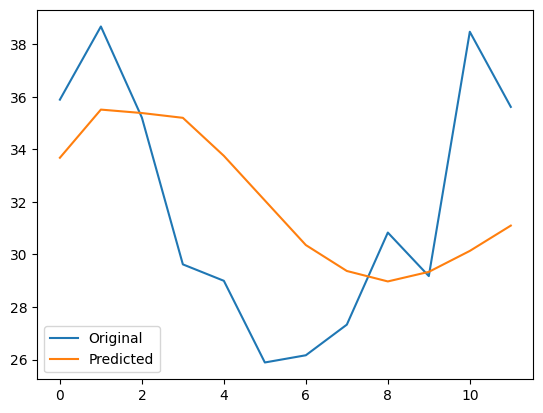

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 20
batch_size = 32
lag=4

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### lag = 6

  9%|▉         | 91/1000 [00:00<00:04, 221.48it/s]

Epoch 51/1000, Loss: 0.0351


 14%|█▎        | 136/1000 [00:00<00:03, 218.31it/s]

Epoch 101/1000, Loss: 0.0237


 18%|█▊        | 180/1000 [00:00<00:03, 210.42it/s]

Epoch 151/1000, Loss: 0.0180


 22%|██▎       | 225/1000 [00:01<00:03, 213.28it/s]

Epoch 201/1000, Loss: 0.0158


 29%|██▉       | 291/1000 [00:01<00:03, 212.40it/s]

Epoch 251/1000, Loss: 0.0150


 33%|███▎      | 334/1000 [00:01<00:03, 205.04it/s]

Epoch 301/1000, Loss: 0.0145


 38%|███▊      | 378/1000 [00:01<00:03, 206.34it/s]

Epoch 351/1000, Loss: 0.0142


 42%|████▏     | 420/1000 [00:02<00:02, 199.83it/s]

Epoch 401/1000, Loss: 0.0139


 49%|████▉     | 494/1000 [00:02<00:02, 232.16it/s]

Epoch 451/1000, Loss: 0.0136
Epoch 501/1000, Loss: 0.0134


 58%|█████▊    | 584/1000 [00:02<00:01, 273.33it/s]

Epoch 551/1000, Loss: 0.0132
Epoch 601/1000, Loss: 0.0130


 70%|███████   | 704/1000 [00:03<00:01, 289.28it/s]

Epoch 651/1000, Loss: 0.0128
Epoch 701/1000, Loss: 0.0126


 80%|████████  | 801/1000 [00:03<00:00, 308.74it/s]

Epoch 751/1000, Loss: 0.0125
Epoch 801/1000, Loss: 0.0123


 90%|████████▉ | 898/1000 [00:03<00:00, 303.24it/s]

Epoch 851/1000, Loss: 0.0122
Epoch 901/1000, Loss: 0.0121


100%|██████████| 1000/1000 [00:04<00:00, 249.18it/s]

Epoch 951/1000, Loss: 0.0120
Epoch 1001/1000, Loss: 0.0119
Erro MSE = 18.903 
Erro MAE = 3.637


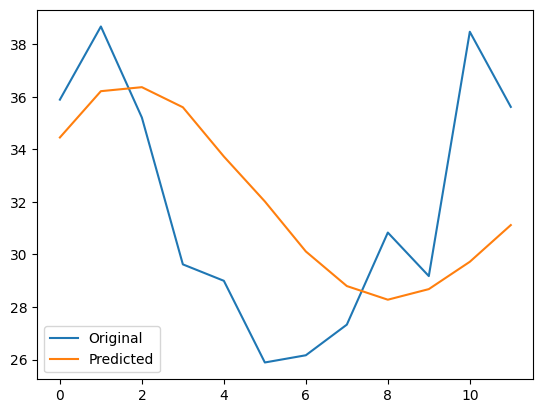

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 20
batch_size = 32
lag=6

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### lag = 10

 10%|▉         | 95/1000 [00:00<00:02, 304.18it/s]

Epoch 51/1000, Loss: 0.0414
Epoch 101/1000, Loss: 0.0262


 19%|█▉        | 191/1000 [00:00<00:02, 310.13it/s]

Epoch 151/1000, Loss: 0.0191
Epoch 201/1000, Loss: 0.0171


 28%|██▊       | 285/1000 [00:00<00:02, 300.02it/s]

Epoch 251/1000, Loss: 0.0164
Epoch 301/1000, Loss: 0.0159


 38%|███▊      | 384/1000 [00:01<00:01, 317.04it/s]

Epoch 351/1000, Loss: 0.0155
Epoch 401/1000, Loss: 0.0151


 51%|█████▏    | 513/1000 [00:01<00:01, 312.59it/s]

Epoch 451/1000, Loss: 0.0147
Epoch 501/1000, Loss: 0.0143


 61%|██████    | 607/1000 [00:01<00:01, 308.47it/s]

Epoch 551/1000, Loss: 0.0140
Epoch 601/1000, Loss: 0.0137


 70%|███████   | 702/1000 [00:02<00:00, 303.32it/s]

Epoch 651/1000, Loss: 0.0134
Epoch 701/1000, Loss: 0.0132


 80%|███████▉  | 796/1000 [00:02<00:00, 301.38it/s]

Epoch 751/1000, Loss: 0.0130
Epoch 801/1000, Loss: 0.0128


 89%|████████▉ | 893/1000 [00:02<00:00, 311.01it/s]

Epoch 851/1000, Loss: 0.0126
Epoch 901/1000, Loss: 0.0125


100%|██████████| 1000/1000 [00:03<00:00, 308.15it/s]

Epoch 951/1000, Loss: 0.0123
Epoch 1001/1000, Loss: 0.0122
Erro MSE = 9.092 
Erro MAE = 2.316


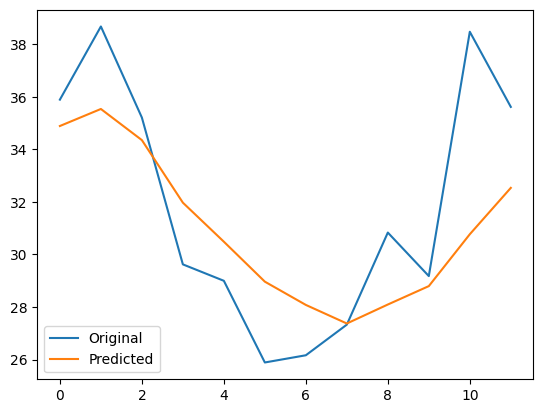

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 20
batch_size = 32
lag=10

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### lag = 11

 10%|▉         | 99/1000 [00:00<00:02, 316.62it/s]

Epoch 51/1000, Loss: 0.0288
Epoch 101/1000, Loss: 0.0171


 20%|█▉        | 198/1000 [00:00<00:02, 322.38it/s]

Epoch 151/1000, Loss: 0.0136
Epoch 201/1000, Loss: 0.0130


 30%|██▉       | 295/1000 [00:00<00:02, 311.01it/s]

Epoch 251/1000, Loss: 0.0128
Epoch 301/1000, Loss: 0.0126


 39%|███▉      | 391/1000 [00:01<00:01, 311.17it/s]

Epoch 351/1000, Loss: 0.0123
Epoch 401/1000, Loss: 0.0121


 49%|████▉     | 491/1000 [00:01<00:01, 318.66it/s]

Epoch 451/1000, Loss: 0.0119
Epoch 501/1000, Loss: 0.0117


 59%|█████▉    | 591/1000 [00:01<00:01, 326.01it/s]

Epoch 551/1000, Loss: 0.0116
Epoch 601/1000, Loss: 0.0114


 69%|██████▊   | 686/1000 [00:02<00:01, 296.34it/s]

Epoch 651/1000, Loss: 0.0113
Epoch 701/1000, Loss: 0.0112


 78%|███████▊  | 782/1000 [00:02<00:00, 307.58it/s]

Epoch 751/1000, Loss: 0.0111
Epoch 801/1000, Loss: 0.0110


 91%|█████████▏| 913/1000 [00:02<00:00, 309.87it/s]

Epoch 851/1000, Loss: 0.0109
Epoch 901/1000, Loss: 0.0109


100%|██████████| 1000/1000 [00:03<00:00, 313.08it/s]


Epoch 951/1000, Loss: 0.0108
Epoch 1001/1000, Loss: 0.0107
Erro MSE = 10.355 
Erro MAE = 2.388


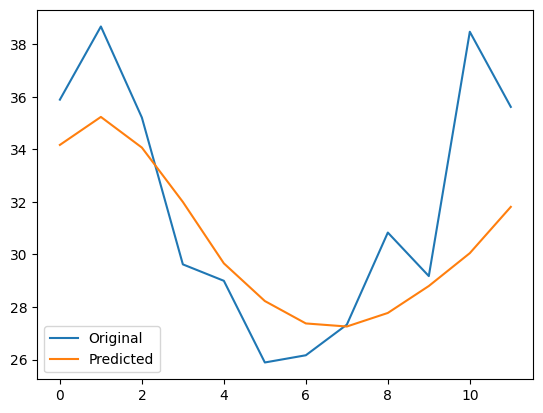

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 20
batch_size = 32
lag=11

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### Reposta

A mudança na janela de entrada, mostrou resultados inversamente correlacionados a precisão da rede, onde quanto menor a janela, maior o erro. E isso faz sentido, quando entendemos que a mudança na janela de entreda da rede, afeta diretamente a quantidade de meses anteriores que a rede terá para aprender. Logo, com lag menor, menos meses ela tem para aprender e pior são os resultados. Analisando os resultados anteriores, manterei lag = 12 para as análises a seguir.

#### 4.	Modifique a topologia da rede para obter um melhor desempenho. Altere seus parâmetros (e.g. número de processadores na camada escondida, tipo de função na camada de saída) e avalie o desempenho.

In [ ]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    #self.out = nn.Sigmoid() #Para o caso binário

  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

##### Hidden Neurons

###### HN = 5

  9%|▉         | 88/1000 [00:00<00:04, 203.15it/s]

Epoch 51/1000, Loss: 0.0126


 13%|█▎        | 130/1000 [00:00<00:04, 201.02it/s]

Epoch 101/1000, Loss: 0.0116


 17%|█▋        | 170/1000 [00:00<00:04, 182.60it/s]

Epoch 151/1000, Loss: 0.0111


 23%|██▎       | 230/1000 [00:01<00:04, 188.42it/s]

Epoch 201/1000, Loss: 0.0107


 29%|██▉       | 289/1000 [00:01<00:03, 186.70it/s]

Epoch 251/1000, Loss: 0.0104


 33%|███▎      | 329/1000 [00:01<00:03, 185.09it/s]

Epoch 301/1000, Loss: 0.0102


 39%|███▉      | 389/1000 [00:02<00:03, 192.63it/s]

Epoch 351/1000, Loss: 0.0099


 43%|████▎     | 428/1000 [00:02<00:03, 181.36it/s]

Epoch 401/1000, Loss: 0.0097


 46%|████▋     | 465/1000 [00:02<00:03, 176.42it/s]

Epoch 451/1000, Loss: 0.0096


 51%|█████     | 512/1000 [00:03<00:04, 102.35it/s]

Epoch 501/1000, Loss: 0.0095


 56%|█████▋    | 564/1000 [00:03<00:05, 83.46it/s]

Epoch 551/1000, Loss: 0.0094


 61%|██████    | 610/1000 [00:04<00:04, 81.55it/s]

Epoch 601/1000, Loss: 0.0093


 66%|██████▋   | 664/1000 [00:04<00:03, 85.49it/s]

Epoch 651/1000, Loss: 0.0092


 71%|███████   | 711/1000 [00:05<00:03, 83.67it/s]

Epoch 701/1000, Loss: 0.0091


 78%|███████▊  | 778/1000 [00:05<00:01, 149.90it/s]

Epoch 751/1000, Loss: 0.0090


 84%|████████▍ | 839/1000 [00:06<00:00, 180.47it/s]

Epoch 801/1000, Loss: 0.0089


 88%|████████▊ | 883/1000 [00:06<00:00, 198.25it/s]

Epoch 851/1000, Loss: 0.0089


 93%|█████████▎| 926/1000 [00:06<00:00, 200.59it/s]

Epoch 901/1000, Loss: 0.0089


 99%|█████████▉| 992/1000 [00:07<00:00, 206.44it/s]

Epoch 951/1000, Loss: 0.0089


100%|██████████| 1000/1000 [00:07<00:00, 141.18it/s]


Epoch 1001/1000, Loss: 0.0089
Erro MSE = 9.405 
Erro MAE = 2.432


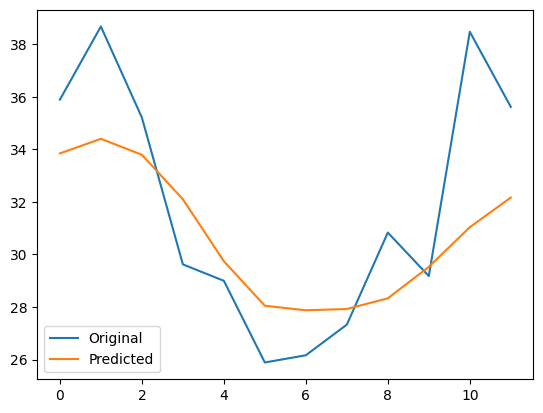

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 5
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='relu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### HN = 6

  9%|▊         | 87/1000 [00:00<00:04, 196.09it/s]

Epoch 51/1000, Loss: 0.0351


 13%|█▎        | 128/1000 [00:00<00:04, 199.34it/s]

Epoch 101/1000, Loss: 0.0220


 17%|█▋        | 169/1000 [00:00<00:04, 189.26it/s]

Epoch 151/1000, Loss: 0.0161


 23%|██▎       | 230/1000 [00:01<00:04, 186.96it/s]

Epoch 201/1000, Loss: 0.0148


 29%|██▊       | 287/1000 [00:01<00:03, 182.40it/s]

Epoch 251/1000, Loss: 0.0145


 33%|███▎      | 330/1000 [00:01<00:03, 197.68it/s]

Epoch 301/1000, Loss: 0.0144


 37%|███▋      | 373/1000 [00:01<00:03, 198.69it/s]

Epoch 351/1000, Loss: 0.0142


 44%|████▎     | 437/1000 [00:02<00:02, 204.03it/s]

Epoch 401/1000, Loss: 0.0140


 48%|████▊     | 479/1000 [00:02<00:02, 186.78it/s]

Epoch 451/1000, Loss: 0.0138


 54%|█████▍    | 540/1000 [00:02<00:02, 190.96it/s]

Epoch 501/1000, Loss: 0.0136


 58%|█████▊    | 581/1000 [00:03<00:02, 194.35it/s]

Epoch 551/1000, Loss: 0.0134


 62%|██████▏   | 621/1000 [00:03<00:01, 190.84it/s]

Epoch 601/1000, Loss: 0.0133


 68%|██████▊   | 682/1000 [00:03<00:01, 190.75it/s]

Epoch 651/1000, Loss: 0.0131


 72%|███████▏  | 723/1000 [00:03<00:01, 186.03it/s]

Epoch 701/1000, Loss: 0.0129


 78%|███████▊  | 784/1000 [00:04<00:01, 194.18it/s]

Epoch 751/1000, Loss: 0.0128


 82%|████████▎ | 825/1000 [00:04<00:00, 189.81it/s]

Epoch 801/1000, Loss: 0.0127


 88%|████████▊ | 884/1000 [00:04<00:00, 184.70it/s]

Epoch 851/1000, Loss: 0.0125


 92%|█████████▏| 924/1000 [00:04<00:00, 190.28it/s]

Epoch 901/1000, Loss: 0.0124


 98%|█████████▊| 984/1000 [00:05<00:00, 183.55it/s]

Epoch 951/1000, Loss: 0.0123


100%|██████████| 1000/1000 [00:05<00:00, 188.79it/s]


Epoch 1001/1000, Loss: 0.0122
Erro MSE = 9.056 
Erro MAE = 2.271


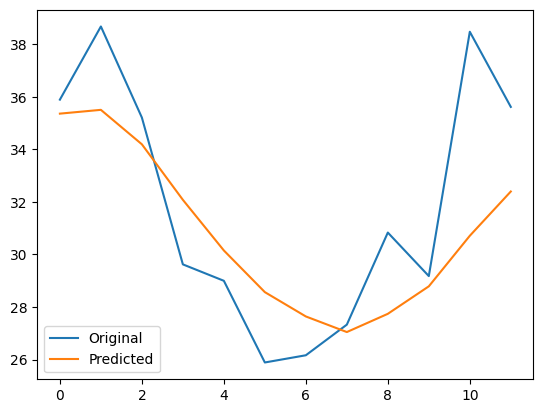

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### HN = 9

  9%|▉         | 90/1000 [00:00<00:04, 203.31it/s]

Epoch 51/1000, Loss: 0.0293


 13%|█▎        | 132/1000 [00:00<00:04, 203.64it/s]

Epoch 101/1000, Loss: 0.0172


 17%|█▋        | 172/1000 [00:00<00:04, 173.16it/s]

Epoch 151/1000, Loss: 0.0135


 23%|██▎       | 234/1000 [00:01<00:03, 193.19it/s]

Epoch 201/1000, Loss: 0.0130


 27%|██▋       | 273/1000 [00:01<00:03, 185.28it/s]

Epoch 251/1000, Loss: 0.0129


 33%|███▎      | 333/1000 [00:01<00:03, 190.56it/s]

Epoch 301/1000, Loss: 0.0128


 37%|███▋      | 371/1000 [00:01<00:03, 173.97it/s]

Epoch 351/1000, Loss: 0.0126


 43%|████▎     | 429/1000 [00:02<00:03, 184.47it/s]

Epoch 401/1000, Loss: 0.0124


 47%|████▋     | 466/1000 [00:02<00:03, 135.74it/s]

Epoch 451/1000, Loss: 0.0123


 53%|█████▎    | 528/1000 [00:03<00:03, 138.78it/s]

Epoch 501/1000, Loss: 0.0121


 57%|█████▋    | 569/1000 [00:03<00:03, 111.30it/s]

Epoch 551/1000, Loss: 0.0120


 62%|██████▏   | 616/1000 [00:03<00:03, 120.22it/s]

Epoch 601/1000, Loss: 0.0119


 67%|██████▋   | 671/1000 [00:04<00:02, 117.49it/s]

Epoch 651/1000, Loss: 0.0118


 72%|███████▏  | 719/1000 [00:04<00:02, 104.89it/s]

Epoch 701/1000, Loss: 0.0117


 76%|███████▌  | 762/1000 [00:05<00:02, 92.60it/s]

Epoch 751/1000, Loss: 0.0116


 82%|████████▏ | 820/1000 [00:05<00:01, 112.34it/s]

Epoch 801/1000, Loss: 0.0115


 88%|████████▊ | 877/1000 [00:06<00:00, 158.82it/s]

Epoch 851/1000, Loss: 0.0114


 94%|█████████▍| 940/1000 [00:06<00:00, 191.73it/s]

Epoch 901/1000, Loss: 0.0113


 98%|█████████▊| 982/1000 [00:06<00:00, 190.97it/s]

Epoch 951/1000, Loss: 0.0112


100%|██████████| 1000/1000 [00:06<00:00, 145.63it/s]


Epoch 1001/1000, Loss: 0.0112
Erro MSE = 9.601 
Erro MAE = 2.305


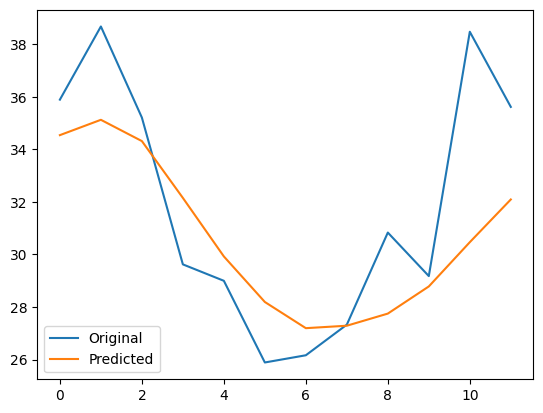

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 9
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### HN = 10

  9%|▊         | 86/1000 [00:00<00:04, 208.64it/s]

Epoch 51/1000, Loss: 0.0402


 13%|█▎        | 128/1000 [00:00<00:04, 197.97it/s]

Epoch 101/1000, Loss: 0.0246


 17%|█▋        | 168/1000 [00:00<00:04, 181.58it/s]

Epoch 151/1000, Loss: 0.0160


 23%|██▎       | 228/1000 [00:01<00:04, 192.42it/s]

Epoch 201/1000, Loss: 0.0139


 27%|██▋       | 270/1000 [00:01<00:03, 197.89it/s]

Epoch 251/1000, Loss: 0.0136


 33%|███▎      | 331/1000 [00:01<00:03, 199.04it/s]

Epoch 301/1000, Loss: 0.0134


 37%|███▋      | 371/1000 [00:01<00:03, 186.10it/s]

Epoch 351/1000, Loss: 0.0132


 43%|████▎     | 431/1000 [00:02<00:03, 177.23it/s]

Epoch 401/1000, Loss: 0.0130


 47%|████▋     | 472/1000 [00:02<00:02, 188.84it/s]

Epoch 451/1000, Loss: 0.0128


 53%|█████▎    | 534/1000 [00:02<00:02, 194.69it/s]

Epoch 501/1000, Loss: 0.0126


 57%|█████▊    | 575/1000 [00:02<00:02, 188.64it/s]

Epoch 551/1000, Loss: 0.0124


 63%|██████▎   | 634/1000 [00:03<00:01, 188.83it/s]

Epoch 601/1000, Loss: 0.0122


 68%|██████▊   | 676/1000 [00:03<00:01, 196.38it/s]

Epoch 651/1000, Loss: 0.0121


 74%|███████▎  | 737/1000 [00:03<00:01, 194.53it/s]

Epoch 701/1000, Loss: 0.0119


 78%|███████▊  | 776/1000 [00:04<00:01, 176.63it/s]

Epoch 751/1000, Loss: 0.0118


 84%|████████▎ | 837/1000 [00:04<00:00, 189.85it/s]

Epoch 801/1000, Loss: 0.0117


 88%|████████▊ | 878/1000 [00:04<00:00, 196.26it/s]

Epoch 851/1000, Loss: 0.0116


 94%|█████████▍| 940/1000 [00:04<00:00, 194.50it/s]

Epoch 901/1000, Loss: 0.0115


 98%|█████████▊| 980/1000 [00:05<00:00, 186.93it/s]

Epoch 951/1000, Loss: 0.0114


100%|██████████| 1000/1000 [00:05<00:00, 190.22it/s]


Epoch 1001/1000, Loss: 0.0113
Erro MSE = 9.79 
Erro MAE = 2.349


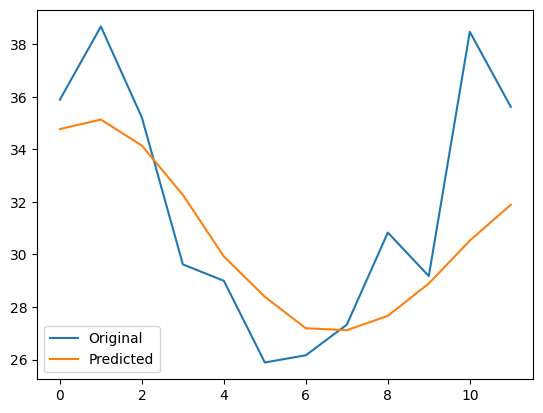

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 10
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### HN = 12

  9%|▉         | 90/1000 [00:00<00:04, 210.54it/s]

Epoch 51/1000, Loss: 0.0293


 14%|█▎        | 136/1000 [00:00<00:04, 209.88it/s]

Epoch 101/1000, Loss: 0.0195


 18%|█▊        | 181/1000 [00:00<00:03, 209.32it/s]

Epoch 151/1000, Loss: 0.0160


 22%|██▏       | 224/1000 [00:01<00:03, 195.14it/s]

Epoch 201/1000, Loss: 0.0151


 29%|██▊       | 287/1000 [00:01<00:03, 195.44it/s]

Epoch 251/1000, Loss: 0.0148


 33%|███▎      | 329/1000 [00:01<00:03, 200.21it/s]

Epoch 301/1000, Loss: 0.0146


 37%|███▋      | 370/1000 [00:01<00:03, 179.29it/s]

Epoch 351/1000, Loss: 0.0143


 43%|████▎     | 433/1000 [00:02<00:02, 193.08it/s]

Epoch 401/1000, Loss: 0.0141


 47%|████▋     | 472/1000 [00:02<00:02, 177.84it/s]

Epoch 451/1000, Loss: 0.0138


 53%|█████▎    | 529/1000 [00:02<00:02, 169.37it/s]

Epoch 501/1000, Loss: 0.0136


 56%|█████▋    | 565/1000 [00:03<00:02, 161.21it/s]

Epoch 551/1000, Loss: 0.0134


 61%|██████    | 611/1000 [00:03<00:03, 115.21it/s]

Epoch 601/1000, Loss: 0.0132


 67%|██████▋   | 667/1000 [00:04<00:03, 95.31it/s]

Epoch 651/1000, Loss: 0.0130


 71%|███████▏  | 713/1000 [00:04<00:02, 105.70it/s]

Epoch 701/1000, Loss: 0.0129


 77%|███████▋  | 766/1000 [00:05<00:02, 97.22it/s] 

Epoch 751/1000, Loss: 0.0127


 82%|████████▏ | 816/1000 [00:05<00:01, 94.41it/s]

Epoch 801/1000, Loss: 0.0125


 90%|█████████ | 903/1000 [00:05<00:00, 223.97it/s]

Epoch 851/1000, Loss: 0.0124
Epoch 901/1000, Loss: 0.0123


100%|██████████| 1000/1000 [00:06<00:00, 159.20it/s]

Epoch 951/1000, Loss: 0.0122
Epoch 1001/1000, Loss: 0.0121
Erro MSE = 9.619 
Erro MAE = 2.392


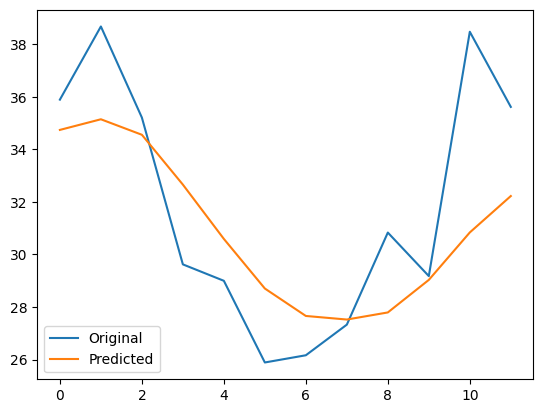

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 12
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### HN = 15

 10%|█         | 103/1000 [00:00<00:02, 320.67it/s]

Epoch 51/1000, Loss: 0.0411
Epoch 101/1000, Loss: 0.0263


 20%|██        | 200/1000 [00:00<00:02, 301.02it/s]

Epoch 151/1000, Loss: 0.0180
Epoch 201/1000, Loss: 0.0157


 29%|██▉       | 294/1000 [00:00<00:02, 298.92it/s]

Epoch 251/1000, Loss: 0.0153
Epoch 301/1000, Loss: 0.0151


 38%|███▊      | 385/1000 [00:01<00:02, 292.63it/s]

Epoch 351/1000, Loss: 0.0148
Epoch 401/1000, Loss: 0.0145


 51%|█████     | 507/1000 [00:01<00:01, 284.03it/s]

Epoch 451/1000, Loss: 0.0143
Epoch 501/1000, Loss: 0.0140


 60%|█████▉    | 599/1000 [00:02<00:01, 296.84it/s]

Epoch 551/1000, Loss: 0.0137
Epoch 601/1000, Loss: 0.0135


 69%|██████▉   | 694/1000 [00:02<00:00, 307.52it/s]

Epoch 651/1000, Loss: 0.0133
Epoch 701/1000, Loss: 0.0131


 79%|███████▉  | 791/1000 [00:02<00:00, 300.20it/s]

Epoch 751/1000, Loss: 0.0129
Epoch 801/1000, Loss: 0.0127


 88%|████████▊ | 885/1000 [00:02<00:00, 303.78it/s]

Epoch 851/1000, Loss: 0.0126
Epoch 901/1000, Loss: 0.0124


100%|██████████| 1000/1000 [00:03<00:00, 299.92it/s]


Epoch 951/1000, Loss: 0.0123
Epoch 1001/1000, Loss: 0.0122
Erro MSE = 9.594 
Erro MAE = 2.316


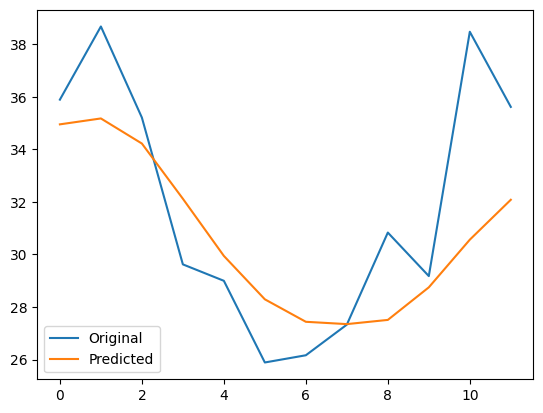

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 15
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### HN = 17

  9%|▉         | 93/1000 [00:00<00:03, 301.53it/s]

Epoch 51/1000, Loss: 0.0325
Epoch 101/1000, Loss: 0.0197


 19%|█▉        | 188/1000 [00:00<00:02, 309.18it/s]

Epoch 151/1000, Loss: 0.0149
Epoch 201/1000, Loss: 0.0139


 27%|██▋       | 274/1000 [00:01<00:03, 212.31it/s]

Epoch 251/1000, Loss: 0.0137


 32%|███▏      | 318/1000 [00:01<00:03, 181.55it/s]

Epoch 301/1000, Loss: 0.0135


 38%|███▊      | 377/1000 [00:01<00:04, 148.77it/s]

Epoch 351/1000, Loss: 0.0133


 43%|████▎     | 433/1000 [00:02<00:03, 167.78it/s]

Epoch 401/1000, Loss: 0.0131


 47%|████▋     | 473/1000 [00:02<00:02, 177.28it/s]

Epoch 451/1000, Loss: 0.0129


 54%|█████▍    | 541/1000 [00:02<00:02, 198.32it/s]

Epoch 501/1000, Loss: 0.0127


 58%|█████▊    | 581/1000 [00:02<00:02, 180.62it/s]

Epoch 551/1000, Loss: 0.0125


 62%|██████▏   | 622/1000 [00:03<00:02, 187.87it/s]

Epoch 601/1000, Loss: 0.0123


 68%|██████▊   | 685/1000 [00:03<00:01, 190.72it/s]

Epoch 651/1000, Loss: 0.0121


 72%|███████▎  | 725/1000 [00:03<00:01, 183.78it/s]

Epoch 701/1000, Loss: 0.0120


 78%|███████▊  | 781/1000 [00:04<00:01, 168.18it/s]

Epoch 751/1000, Loss: 0.0118


 84%|████████▍ | 839/1000 [00:04<00:00, 181.69it/s]

Epoch 801/1000, Loss: 0.0117


 88%|████████▊ | 879/1000 [00:04<00:00, 166.95it/s]

Epoch 851/1000, Loss: 0.0116


 94%|█████████▍| 941/1000 [00:04<00:00, 186.26it/s]

Epoch 901/1000, Loss: 0.0115


 98%|█████████▊| 979/1000 [00:05<00:00, 180.99it/s]

Epoch 951/1000, Loss: 0.0114


100%|██████████| 1000/1000 [00:05<00:00, 187.97it/s]


Epoch 1001/1000, Loss: 0.0113
Erro MSE = 10.169 
Erro MAE = 2.383


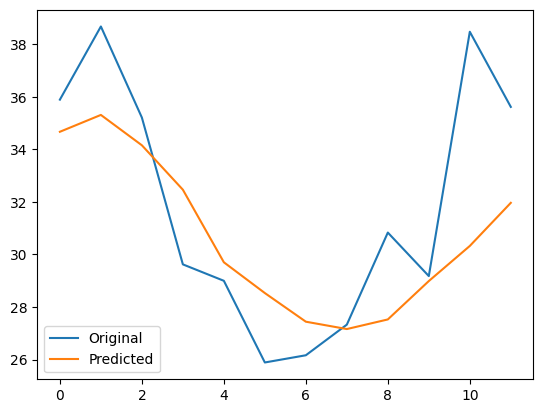

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 17
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### HN = 25

  6%|▋         | 64/1000 [00:00<00:09, 99.57it/s] 

Epoch 51/1000, Loss: 0.0380


 12%|█▏        | 116/1000 [00:01<00:09, 92.65it/s]

Epoch 101/1000, Loss: 0.0227


 16%|█▋        | 165/1000 [00:01<00:08, 94.32it/s]

Epoch 151/1000, Loss: 0.0165


 22%|██▏       | 215/1000 [00:02<00:08, 90.42it/s]

Epoch 201/1000, Loss: 0.0153


 26%|██▋       | 264/1000 [00:02<00:08, 84.79it/s]

Epoch 251/1000, Loss: 0.0149


 33%|███▎      | 333/1000 [00:03<00:04, 151.29it/s]

Epoch 301/1000, Loss: 0.0146


 37%|███▋      | 367/1000 [00:03<00:04, 154.77it/s]

Epoch 351/1000, Loss: 0.0144


 42%|████▏     | 424/1000 [00:03<00:03, 175.29it/s]

Epoch 401/1000, Loss: 0.0141


 48%|████▊     | 481/1000 [00:04<00:02, 179.39it/s]

Epoch 451/1000, Loss: 0.0138


 52%|█████▏    | 517/1000 [00:04<00:03, 157.16it/s]

Epoch 501/1000, Loss: 0.0136


 57%|█████▋    | 572/1000 [00:04<00:02, 173.66it/s]

Epoch 551/1000, Loss: 0.0134


 63%|██████▎   | 628/1000 [00:04<00:02, 179.62it/s]

Epoch 601/1000, Loss: 0.0132


 69%|██████▊   | 687/1000 [00:05<00:01, 186.60it/s]

Epoch 651/1000, Loss: 0.0130


 72%|███████▎  | 725/1000 [00:05<00:01, 183.64it/s]

Epoch 701/1000, Loss: 0.0128


 78%|███████▊  | 785/1000 [00:05<00:01, 192.22it/s]

Epoch 751/1000, Loss: 0.0127


 83%|████████▎ | 827/1000 [00:05<00:00, 200.47it/s]

Epoch 801/1000, Loss: 0.0126


 87%|████████▋ | 870/1000 [00:06<00:00, 204.82it/s]

Epoch 851/1000, Loss: 0.0124


 94%|█████████▎| 935/1000 [00:06<00:00, 201.17it/s]

Epoch 901/1000, Loss: 0.0123


 98%|█████████▊| 976/1000 [00:06<00:00, 178.59it/s]

Epoch 951/1000, Loss: 0.0122


100%|██████████| 1000/1000 [00:06<00:00, 144.92it/s]


Epoch 1001/1000, Loss: 0.0121
Erro MSE = 10.287 
Erro MAE = 2.429


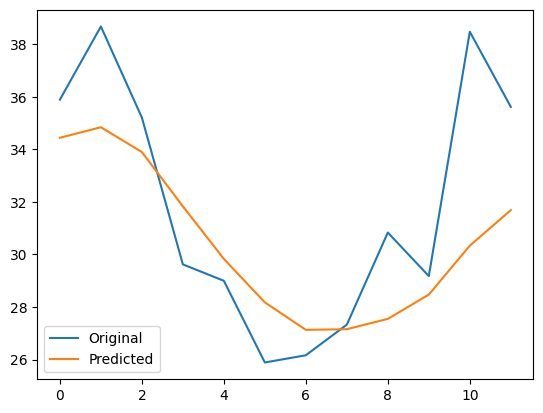

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 25
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### HN = 30

  8%|▊         | 83/1000 [00:00<00:05, 182.45it/s]

Epoch 51/1000, Loss: 0.0281


 12%|█▏        | 122/1000 [00:00<00:04, 179.37it/s]

Epoch 101/1000, Loss: 0.0188


 18%|█▊        | 177/1000 [00:01<00:05, 162.47it/s]

Epoch 151/1000, Loss: 0.0165


 23%|██▎       | 232/1000 [00:01<00:04, 171.17it/s]

Epoch 201/1000, Loss: 0.0160


 27%|██▋       | 271/1000 [00:01<00:04, 172.14it/s]

Epoch 251/1000, Loss: 0.0157


 32%|███▎      | 325/1000 [00:01<00:03, 169.54it/s]

Epoch 301/1000, Loss: 0.0153


 38%|███▊      | 383/1000 [00:02<00:03, 180.29it/s]

Epoch 351/1000, Loss: 0.0150


 42%|████▎     | 425/1000 [00:02<00:02, 193.29it/s]

Epoch 401/1000, Loss: 0.0146


 47%|████▋     | 466/1000 [00:02<00:02, 194.46it/s]

Epoch 451/1000, Loss: 0.0143


 53%|█████▎    | 528/1000 [00:02<00:02, 194.91it/s]

Epoch 501/1000, Loss: 0.0140


 59%|█████▉    | 589/1000 [00:03<00:02, 190.33it/s]

Epoch 551/1000, Loss: 0.0138


 63%|██████▎   | 629/1000 [00:03<00:01, 190.54it/s]

Epoch 601/1000, Loss: 0.0135


 67%|██████▋   | 669/1000 [00:03<00:01, 193.69it/s]

Epoch 651/1000, Loss: 0.0133


 73%|███████▎  | 729/1000 [00:04<00:01, 186.45it/s]

Epoch 701/1000, Loss: 0.0131


 77%|███████▋  | 768/1000 [00:04<00:01, 187.82it/s]

Epoch 751/1000, Loss: 0.0129


 83%|████████▎ | 830/1000 [00:04<00:00, 191.37it/s]

Epoch 801/1000, Loss: 0.0128


 87%|████████▋ | 872/1000 [00:04<00:00, 198.06it/s]

Epoch 851/1000, Loss: 0.0126


 94%|█████████▎| 936/1000 [00:05<00:00, 205.56it/s]

Epoch 901/1000, Loss: 0.0125


 98%|█████████▊| 978/1000 [00:05<00:00, 188.99it/s]

Epoch 951/1000, Loss: 0.0124


100%|██████████| 1000/1000 [00:05<00:00, 182.52it/s]


Epoch 1001/1000, Loss: 0.0122
Erro MSE = 10.647 
Erro MAE = 2.494


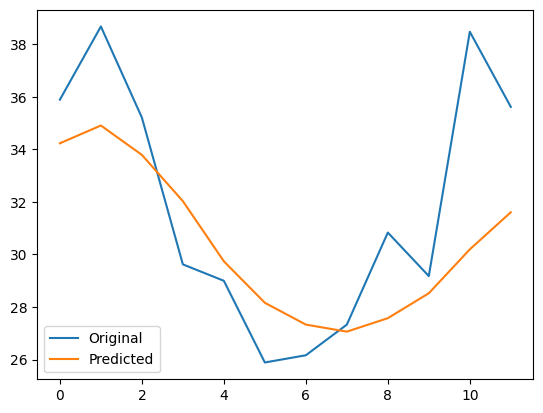

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 30
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### HN = 100

  7%|▋         | 67/1000 [00:00<00:08, 112.37it/s]

Epoch 51/1000, Loss: 0.0224


 13%|█▎        | 126/1000 [00:01<00:08, 106.08it/s]

Epoch 101/1000, Loss: 0.0149


 16%|█▌        | 162/1000 [00:01<00:08, 101.50it/s]

Epoch 151/1000, Loss: 0.0140


 21%|██        | 210/1000 [00:02<00:07, 102.75it/s]

Epoch 201/1000, Loss: 0.0138


 26%|██▌       | 262/1000 [00:02<00:08, 87.90it/s]

Epoch 251/1000, Loss: 0.0135


 33%|███▎      | 327/1000 [00:03<00:05, 126.04it/s]

Epoch 301/1000, Loss: 0.0133


 38%|███▊      | 379/1000 [00:03<00:04, 154.95it/s]

Epoch 351/1000, Loss: 0.0130


 44%|████▎     | 435/1000 [00:03<00:03, 174.87it/s]

Epoch 401/1000, Loss: 0.0129


 47%|████▋     | 473/1000 [00:04<00:02, 180.76it/s]

Epoch 451/1000, Loss: 0.0127


 53%|█████▎    | 529/1000 [00:04<00:02, 174.32it/s]

Epoch 501/1000, Loss: 0.0125


 58%|█████▊    | 585/1000 [00:04<00:02, 179.19it/s]

Epoch 551/1000, Loss: 0.0124


 62%|██████▎   | 625/1000 [00:04<00:01, 188.58it/s]

Epoch 601/1000, Loss: 0.0123


 67%|██████▋   | 666/1000 [00:05<00:01, 168.94it/s]

Epoch 651/1000, Loss: 0.0122


 72%|███████▏  | 720/1000 [00:05<00:01, 151.11it/s]

Epoch 701/1000, Loss: 0.0121


 77%|███████▋  | 773/1000 [00:05<00:01, 157.67it/s]

Epoch 751/1000, Loss: 0.0120


 83%|████████▎ | 830/1000 [00:06<00:00, 179.36it/s]

Epoch 801/1000, Loss: 0.0119


 89%|████████▉ | 888/1000 [00:06<00:00, 182.11it/s]

Epoch 851/1000, Loss: 0.0118


 93%|█████████▎| 927/1000 [00:06<00:00, 181.68it/s]

Epoch 901/1000, Loss: 0.0118


 98%|█████████▊| 985/1000 [00:07<00:00, 180.51it/s]

Epoch 951/1000, Loss: 0.0117


100%|██████████| 1000/1000 [00:07<00:00, 140.91it/s]


Epoch 1001/1000, Loss: 0.0116
Erro MSE = 11.802 
Erro MAE = 2.571


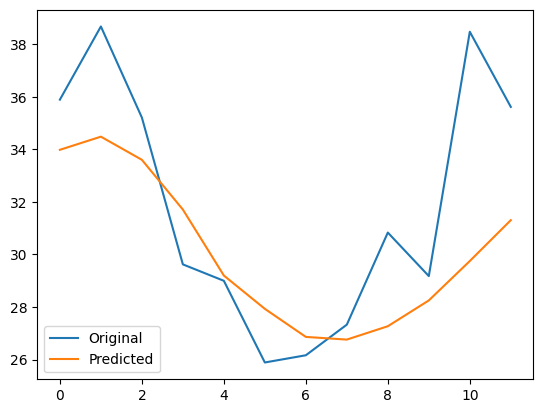

In [ ]:
prev = 12
lr = 0.05
epochs = 1000
n_output = 1
hidden_neurons = 100
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### HN - Resultado
A rede com 6 neurônios na camada escondida apresentou o melhor resultado. Para definir os valores iniciais que iria analisar, utilizei o cálculo:
  Hidden Neurons = [(2/3)*n_input]+n_output.
  e também escolhi valores de maneira arbitrária.

##### Learning Rate

###### lr = 0,01

  9%|▉         | 94/1000 [00:00<00:02, 310.29it/s]

Epoch 51/1000, Loss: 0.0503
Epoch 101/1000, Loss: 0.0483


 19%|█▊        | 187/1000 [00:00<00:02, 295.53it/s]

Epoch 151/1000, Loss: 0.0463
Epoch 201/1000, Loss: 0.0441


 30%|███       | 304/1000 [00:01<00:02, 283.38it/s]

Epoch 251/1000, Loss: 0.0419
Epoch 301/1000, Loss: 0.0394


 40%|███▉      | 399/1000 [00:01<00:01, 302.03it/s]

Epoch 351/1000, Loss: 0.0369
Epoch 401/1000, Loss: 0.0342


 49%|████▉     | 494/1000 [00:01<00:01, 305.85it/s]

Epoch 451/1000, Loss: 0.0314
Epoch 501/1000, Loss: 0.0288


 59%|█████▉    | 588/1000 [00:02<00:01, 288.33it/s]

Epoch 551/1000, Loss: 0.0262
Epoch 601/1000, Loss: 0.0239


 68%|██████▊   | 682/1000 [00:02<00:01, 296.32it/s]

Epoch 651/1000, Loss: 0.0218
Epoch 701/1000, Loss: 0.0200


 81%|████████  | 807/1000 [00:02<00:00, 304.81it/s]

Epoch 751/1000, Loss: 0.0186
Epoch 801/1000, Loss: 0.0175


 90%|█████████ | 901/1000 [00:03<00:00, 299.65it/s]

Epoch 851/1000, Loss: 0.0166
Epoch 901/1000, Loss: 0.0159


100%|██████████| 1000/1000 [00:03<00:00, 294.82it/s]

Epoch 951/1000, Loss: 0.0154
Epoch 1001/1000, Loss: 0.0150


Erro MSE = 10.27 
Erro MAE = 2.623


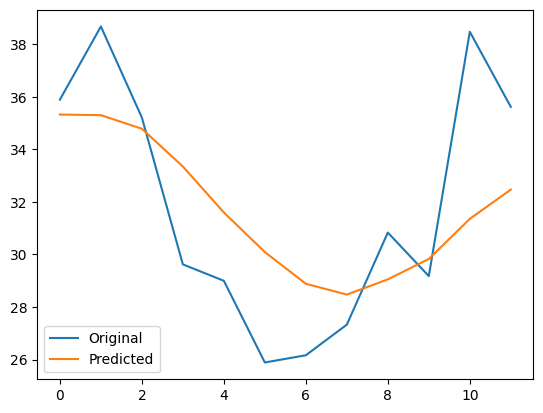

In [ ]:
prev = 12
lr = 0.01
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### lr = 0,02

  9%|▉         | 93/1000 [00:00<00:04, 216.70it/s]

Epoch 51/1000, Loss: 0.0454


 14%|█▎        | 136/1000 [00:00<00:04, 203.45it/s]

Epoch 101/1000, Loss: 0.0401


 18%|█▊        | 178/1000 [00:00<00:04, 184.94it/s]

Epoch 151/1000, Loss: 0.0344


 21%|██▏       | 214/1000 [00:01<00:06, 115.34it/s]

Epoch 201/1000, Loss: 0.0286


 28%|██▊       | 278/1000 [00:01<00:05, 122.26it/s]

Epoch 251/1000, Loss: 0.0232


 33%|███▎      | 333/1000 [00:02<00:04, 147.77it/s]

Epoch 301/1000, Loss: 0.0190


 39%|███▉      | 393/1000 [00:02<00:03, 181.40it/s]

Epoch 351/1000, Loss: 0.0160


 44%|████▎     | 435/1000 [00:02<00:02, 193.87it/s]

Epoch 401/1000, Loss: 0.0143


 48%|████▊     | 478/1000 [00:02<00:02, 200.06it/s]

Epoch 451/1000, Loss: 0.0134


 54%|█████▍    | 540/1000 [00:03<00:02, 190.64it/s]

Epoch 501/1000, Loss: 0.0129


 58%|█████▊    | 581/1000 [00:03<00:02, 194.14it/s]

Epoch 551/1000, Loss: 0.0127


 62%|██████▏   | 622/1000 [00:03<00:01, 197.69it/s]

Epoch 601/1000, Loss: 0.0126


 68%|██████▊   | 684/1000 [00:04<00:01, 196.38it/s]

Epoch 651/1000, Loss: 0.0126


 72%|███████▏  | 724/1000 [00:04<00:01, 195.59it/s]

Epoch 701/1000, Loss: 0.0126


 76%|███████▋  | 764/1000 [00:04<00:01, 165.07it/s]

Epoch 751/1000, Loss: 0.0125


 82%|████████▏ | 822/1000 [00:04<00:00, 178.27it/s]

Epoch 801/1000, Loss: 0.0125


 88%|████████▊ | 883/1000 [00:05<00:00, 186.42it/s]

Epoch 851/1000, Loss: 0.0124


 92%|█████████▏| 923/1000 [00:05<00:00, 189.11it/s]

Epoch 901/1000, Loss: 0.0124


 99%|█████████▊| 987/1000 [00:05<00:00, 201.46it/s]

Epoch 951/1000, Loss: 0.0123


100%|██████████| 1000/1000 [00:05<00:00, 172.56it/s]


Epoch 1001/1000, Loss: 0.0123
Erro MSE = 9.336 
Erro MAE = 2.334


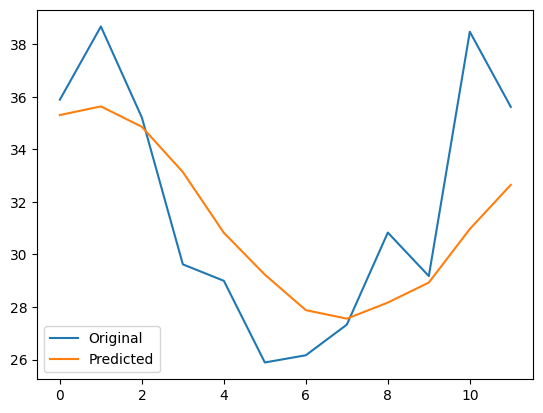

In [ ]:
prev = 12
lr = 0.02
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### lr = 0,03

 10%|▉         | 96/1000 [00:00<00:02, 317.17it/s]

Epoch 51/1000, Loss: 0.0458
Epoch 101/1000, Loss: 0.0398


 19%|█▉        | 193/1000 [00:00<00:02, 307.99it/s]

Epoch 151/1000, Loss: 0.0328
Epoch 201/1000, Loss: 0.0255


 28%|██▊       | 284/1000 [00:00<00:02, 285.28it/s]

Epoch 251/1000, Loss: 0.0195
Epoch 301/1000, Loss: 0.0158


 37%|███▋      | 372/1000 [00:01<00:02, 258.56it/s]

Epoch 351/1000, Loss: 0.0140


 42%|████▏     | 424/1000 [00:01<00:02, 233.29it/s]

Epoch 401/1000, Loss: 0.0134


 50%|████▉     | 495/1000 [00:01<00:02, 223.32it/s]

Epoch 451/1000, Loss: 0.0132


 54%|█████▍    | 541/1000 [00:02<00:02, 217.68it/s]

Epoch 501/1000, Loss: 0.0131


 59%|█████▉    | 588/1000 [00:02<00:01, 223.52it/s]

Epoch 551/1000, Loss: 0.0131


 63%|██████▎   | 634/1000 [00:02<00:01, 212.14it/s]

Epoch 601/1000, Loss: 0.0130


 68%|██████▊   | 678/1000 [00:02<00:01, 211.19it/s]

Epoch 651/1000, Loss: 0.0130


 74%|███████▍  | 745/1000 [00:03<00:01, 213.72it/s]

Epoch 701/1000, Loss: 0.0129


 79%|███████▉  | 789/1000 [00:03<00:01, 210.00it/s]

Epoch 751/1000, Loss: 0.0128


 84%|████████▎ | 835/1000 [00:03<00:00, 217.82it/s]

Epoch 801/1000, Loss: 0.0127


 88%|████████▊ | 880/1000 [00:03<00:00, 218.88it/s]

Epoch 851/1000, Loss: 0.0126


 92%|█████████▎| 925/1000 [00:03<00:00, 219.99it/s]

Epoch 901/1000, Loss: 0.0125


 97%|█████████▋| 970/1000 [00:04<00:00, 211.13it/s]

Epoch 951/1000, Loss: 0.0124


100%|██████████| 1000/1000 [00:04<00:00, 234.35it/s]


Epoch 1001/1000, Loss: 0.0123
Erro MSE = 9.37 
Erro MAE = 2.319


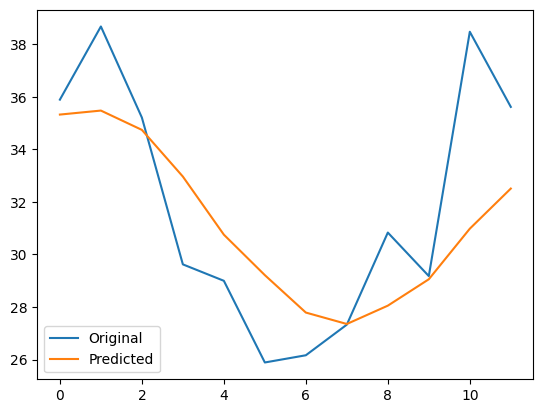

In [ ]:
prev = 12
lr = 0.03
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### lr = 0,04

 10%|▉         | 96/1000 [00:00<00:02, 317.08it/s]

Epoch 51/1000, Loss: 0.0413
Epoch 101/1000, Loss: 0.0291


 19%|█▊        | 187/1000 [00:00<00:02, 276.49it/s]

Epoch 151/1000, Loss: 0.0201
Epoch 201/1000, Loss: 0.0162


 30%|███       | 304/1000 [00:01<00:02, 280.97it/s]

Epoch 251/1000, Loss: 0.0150
Epoch 301/1000, Loss: 0.0145


 40%|███▉      | 397/1000 [00:01<00:02, 296.39it/s]

Epoch 351/1000, Loss: 0.0143
Epoch 401/1000, Loss: 0.0140


 49%|████▉     | 488/1000 [00:01<00:01, 292.20it/s]

Epoch 451/1000, Loss: 0.0138
Epoch 501/1000, Loss: 0.0136


 61%|██████    | 612/1000 [00:02<00:01, 302.30it/s]

Epoch 551/1000, Loss: 0.0134
Epoch 601/1000, Loss: 0.0132


 71%|███████   | 709/1000 [00:02<00:00, 308.15it/s]

Epoch 651/1000, Loss: 0.0130
Epoch 701/1000, Loss: 0.0129


 80%|████████  | 801/1000 [00:02<00:00, 289.18it/s]

Epoch 751/1000, Loss: 0.0127
Epoch 801/1000, Loss: 0.0126


 90%|████████▉ | 898/1000 [00:03<00:00, 306.21it/s]

Epoch 851/1000, Loss: 0.0124
Epoch 901/1000, Loss: 0.0123


100%|██████████| 1000/1000 [00:03<00:00, 294.32it/s]

Epoch 951/1000, Loss: 0.0122
Epoch 1001/1000, Loss: 0.0120
Erro MSE = 9.499 
Erro MAE = 2.326


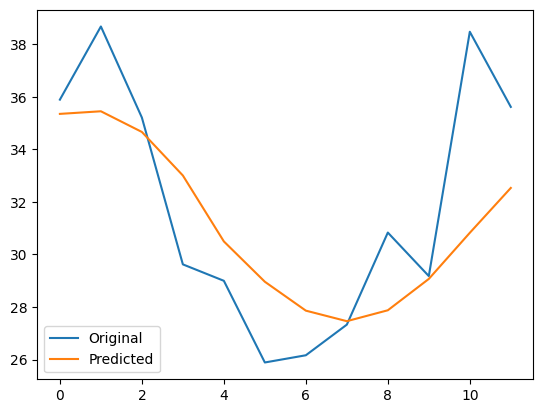

In [ ]:
prev = 12
lr = 0.04
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### lr = 0,06

  9%|▉         | 92/1000 [00:00<00:02, 306.75it/s]

Epoch 51/1000, Loss: 0.0374
Epoch 101/1000, Loss: 0.0227


 19%|█▉        | 188/1000 [00:00<00:02, 308.13it/s]

Epoch 151/1000, Loss: 0.0164
Epoch 201/1000, Loss: 0.0154


 31%|███       | 310/1000 [00:01<00:02, 299.27it/s]

Epoch 251/1000, Loss: 0.0151
Epoch 301/1000, Loss: 0.0148


 40%|████      | 401/1000 [00:01<00:02, 297.25it/s]

Epoch 351/1000, Loss: 0.0145
Epoch 401/1000, Loss: 0.0142


 50%|████▉     | 496/1000 [00:01<00:01, 303.54it/s]

Epoch 451/1000, Loss: 0.0140
Epoch 501/1000, Loss: 0.0137


 59%|█████▉    | 590/1000 [00:01<00:01, 305.50it/s]

Epoch 551/1000, Loss: 0.0134
Epoch 601/1000, Loss: 0.0132


 68%|██████▊   | 682/1000 [00:02<00:01, 294.89it/s]

Epoch 651/1000, Loss: 0.0130
Epoch 701/1000, Loss: 0.0128


 81%|████████  | 806/1000 [00:02<00:00, 301.38it/s]

Epoch 751/1000, Loss: 0.0126
Epoch 801/1000, Loss: 0.0125


 90%|█████████ | 900/1000 [00:03<00:00, 300.62it/s]

Epoch 851/1000, Loss: 0.0123
Epoch 901/1000, Loss: 0.0122


100%|██████████| 1000/1000 [00:03<00:00, 298.91it/s]

Epoch 951/1000, Loss: 0.0120
Epoch 1001/1000, Loss: 0.0119
Erro MSE = 9.317 
Erro MAE = 2.269


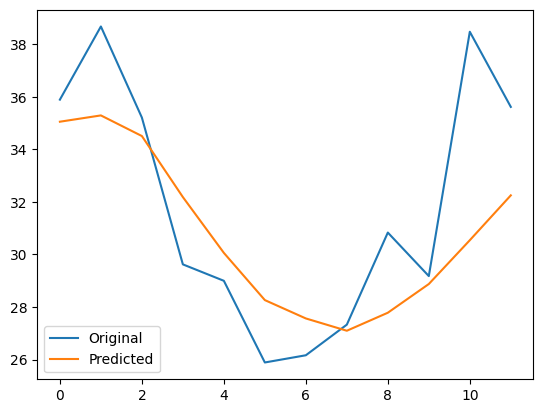

In [ ]:
prev = 12
lr = 0.06
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### lr = 0,1

  9%|▉         | 88/1000 [00:00<00:04, 212.67it/s]

Epoch 51/1000, Loss: 0.0217


 13%|█▎        | 130/1000 [00:00<00:04, 189.79it/s]

Epoch 101/1000, Loss: 0.0156


 18%|█▊        | 175/1000 [00:00<00:04, 204.56it/s]

Epoch 151/1000, Loss: 0.0151


 24%|██▍       | 242/1000 [00:01<00:03, 214.66it/s]

Epoch 201/1000, Loss: 0.0145


 29%|██▊       | 286/1000 [00:01<00:03, 209.39it/s]

Epoch 251/1000, Loss: 0.0140


 33%|███▎      | 330/1000 [00:01<00:03, 212.89it/s]

Epoch 301/1000, Loss: 0.0136


 38%|███▊      | 376/1000 [00:01<00:02, 219.43it/s]

Epoch 351/1000, Loss: 0.0132


 45%|████▍     | 446/1000 [00:02<00:02, 223.31it/s]

Epoch 401/1000, Loss: 0.0128


 49%|████▉     | 493/1000 [00:02<00:02, 228.08it/s]

Epoch 451/1000, Loss: 0.0125


 54%|█████▍    | 539/1000 [00:02<00:02, 224.55it/s]

Epoch 501/1000, Loss: 0.0123


 58%|█████▊    | 584/1000 [00:02<00:01, 219.11it/s]

Epoch 551/1000, Loss: 0.0121


 63%|██████▎   | 627/1000 [00:02<00:01, 204.27it/s]

Epoch 601/1000, Loss: 0.0119


 71%|███████   | 707/1000 [00:03<00:01, 244.60it/s]

Epoch 651/1000, Loss: 0.0117
Epoch 701/1000, Loss: 0.0116


 80%|███████▉  | 795/1000 [00:03<00:00, 273.67it/s]

Epoch 751/1000, Loss: 0.0115
Epoch 801/1000, Loss: 0.0114


 89%|████████▉ | 889/1000 [00:03<00:00, 299.18it/s]

Epoch 851/1000, Loss: 0.0113
Epoch 901/1000, Loss: 0.0112


100%|██████████| 1000/1000 [00:04<00:00, 235.86it/s]

Epoch 951/1000, Loss: 0.0111
Epoch 1001/1000, Loss: 0.0111
Erro MSE = 10.436 
Erro MAE = 2.401


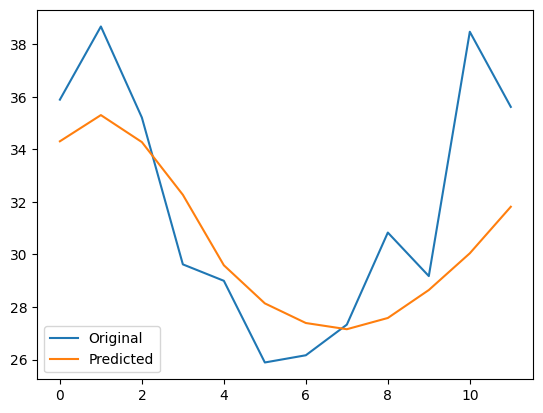

In [ ]:
prev = 12
lr = 0.1
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### lr = 0,25

  9%|▉         | 93/1000 [00:00<00:03, 300.97it/s]

Epoch 51/1000, Loss: 0.0449
Epoch 101/1000, Loss: 0.0425


 19%|█▉        | 189/1000 [00:00<00:02, 313.31it/s]

Epoch 151/1000, Loss: 0.0400
Epoch 201/1000, Loss: 0.0375


 28%|██▊       | 283/1000 [00:00<00:02, 298.22it/s]

Epoch 251/1000, Loss: 0.0348
Epoch 301/1000, Loss: 0.0321


 41%|████      | 409/1000 [00:01<00:01, 305.92it/s]

Epoch 351/1000, Loss: 0.0293
Epoch 401/1000, Loss: 0.0266


 50%|█████     | 502/1000 [00:01<00:01, 301.87it/s]

Epoch 451/1000, Loss: 0.0241
Epoch 501/1000, Loss: 0.0218


 60%|█████▉    | 598/1000 [00:01<00:01, 310.40it/s]

Epoch 551/1000, Loss: 0.0198
Epoch 601/1000, Loss: 0.0181


 69%|██████▉   | 692/1000 [00:02<00:01, 295.39it/s]

Epoch 651/1000, Loss: 0.0168
Epoch 701/1000, Loss: 0.0157


 78%|███████▊  | 785/1000 [00:02<00:00, 299.32it/s]

Epoch 751/1000, Loss: 0.0149
Epoch 801/1000, Loss: 0.0143


 91%|█████████▏| 914/1000 [00:03<00:00, 311.11it/s]

Epoch 851/1000, Loss: 0.0139
Epoch 901/1000, Loss: 0.0136


100%|██████████| 1000/1000 [00:03<00:00, 301.31it/s]


Epoch 951/1000, Loss: 0.0134
Epoch 1001/1000, Loss: 0.0133
Erro MSE = 11.09 
Erro MAE = 2.722


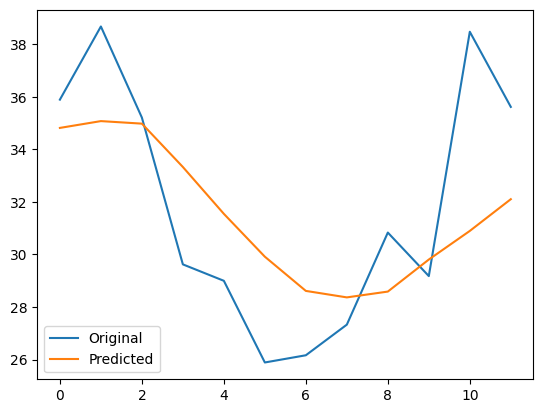

In [ ]:
prev = 12
lr = 0.01
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### lr = 0,5

 10%|█         | 100/1000 [00:00<00:02, 310.30it/s]

Epoch 51/1000, Loss: 0.0128
Epoch 101/1000, Loss: 0.0128


 20%|█▉        | 196/1000 [00:00<00:02, 300.21it/s]

Epoch 151/1000, Loss: 0.0124
Epoch 201/1000, Loss: 0.0120


 29%|██▉       | 289/1000 [00:00<00:02, 296.42it/s]

Epoch 251/1000, Loss: 0.0116
Epoch 301/1000, Loss: 0.0113


 38%|███▊      | 384/1000 [00:01<00:02, 305.24it/s]

Epoch 351/1000, Loss: 0.0111
Epoch 401/1000, Loss: 0.0109


 51%|█████     | 509/1000 [00:01<00:01, 298.64it/s]

Epoch 451/1000, Loss: 0.0107
Epoch 501/1000, Loss: 0.0106


 60%|██████    | 601/1000 [00:01<00:01, 299.95it/s]

Epoch 551/1000, Loss: 0.0105
Epoch 601/1000, Loss: 0.0104


 70%|██████▉   | 695/1000 [00:02<00:01, 298.68it/s]

Epoch 651/1000, Loss: 0.0103
Epoch 701/1000, Loss: 0.0103


 79%|███████▉  | 789/1000 [00:02<00:00, 301.95it/s]

Epoch 751/1000, Loss: 0.0102
Epoch 801/1000, Loss: 0.0102


 89%|████████▊ | 886/1000 [00:02<00:00, 312.67it/s]

Epoch 851/1000, Loss: 0.0101
Epoch 901/1000, Loss: 0.0101


100%|██████████| 1000/1000 [00:03<00:00, 302.96it/s]

Epoch 951/1000, Loss: 0.0101
Epoch 1001/1000, Loss: 0.0100
Erro MSE = 13.152 
Erro MAE = 2.706


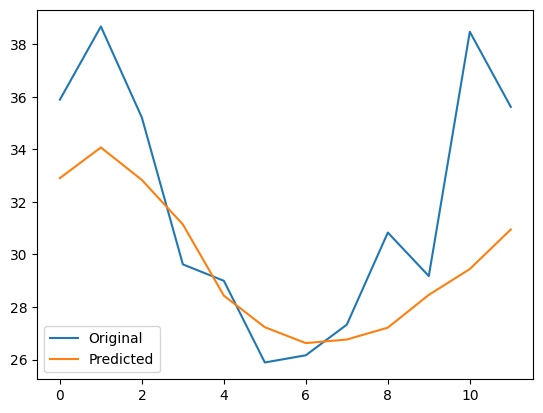

In [ ]:
prev = 12
lr = 0.5
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### lr = 0,9

  9%|▉         | 92/1000 [00:00<00:04, 225.26it/s]

Epoch 51/1000, Loss: 0.0656


 14%|█▎        | 137/1000 [00:00<00:04, 213.24it/s]

Epoch 101/1000, Loss: 0.0646


 18%|█▊        | 182/1000 [00:00<00:03, 213.52it/s]

Epoch 151/1000, Loss: 0.0641


 22%|██▎       | 225/1000 [00:01<00:03, 202.06it/s]

Epoch 201/1000, Loss: 0.0642


 30%|███       | 301/1000 [00:01<00:02, 237.41it/s]

Epoch 251/1000, Loss: 0.1533
Epoch 301/1000, Loss: 0.0739


 39%|███▉      | 390/1000 [00:01<00:02, 275.51it/s]

Epoch 351/1000, Loss: 0.0504
Epoch 401/1000, Loss: 0.0368


 48%|████▊     | 484/1000 [00:01<00:01, 298.40it/s]

Epoch 451/1000, Loss: 0.0244
Epoch 501/1000, Loss: 0.0171


 60%|██████    | 605/1000 [00:02<00:01, 289.18it/s]

Epoch 551/1000, Loss: 0.0090
Epoch 601/1000, Loss: 0.0178


 70%|██████▉   | 698/1000 [00:02<00:01, 300.07it/s]

Epoch 651/1000, Loss: 0.0164
Epoch 701/1000, Loss: 0.0743


 79%|███████▉  | 793/1000 [00:03<00:00, 285.87it/s]

Epoch 751/1000, Loss: 0.0115
Epoch 801/1000, Loss: 0.0983


 89%|████████▉ | 888/1000 [00:03<00:00, 303.10it/s]

Epoch 851/1000, Loss: 0.0118
Epoch 901/1000, Loss: 0.0164


100%|██████████| 1000/1000 [00:03<00:00, 267.65it/s]

Epoch 951/1000, Loss: 0.0878
Epoch 1001/1000, Loss: 0.0118
Erro MSE = 13.105 
Erro MAE = 2.74


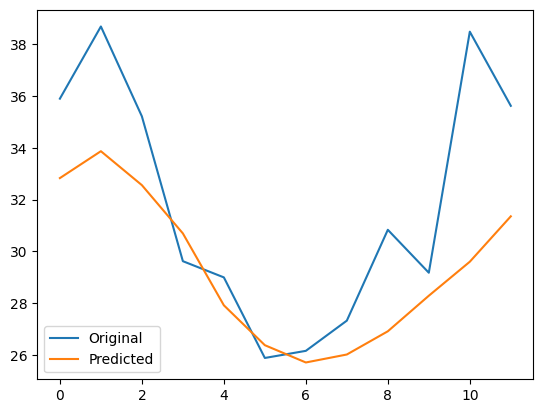

In [ ]:
prev = 12
lr = 0.9
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### lr = coringa
campo para testes aleatórios

 10%|▉         | 95/1000 [00:00<00:02, 308.90it/s]

Epoch 51/1000, Loss: 0.0532
Epoch 101/1000, Loss: 0.0464


 19%|█▊        | 187/1000 [00:00<00:02, 291.26it/s]

Epoch 151/1000, Loss: 0.0392
Epoch 201/1000, Loss: 0.0312


 31%|███       | 307/1000 [00:01<00:02, 290.82it/s]

Epoch 251/1000, Loss: 0.0237
Epoch 301/1000, Loss: 0.0185


 40%|████      | 401/1000 [00:01<00:01, 303.01it/s]

Epoch 351/1000, Loss: 0.0158
Epoch 401/1000, Loss: 0.0148


 50%|████▉     | 495/1000 [00:01<00:01, 296.00it/s]

Epoch 451/1000, Loss: 0.0144
Epoch 501/1000, Loss: 0.0142


 59%|█████▉    | 591/1000 [00:01<00:01, 309.88it/s]

Epoch 551/1000, Loss: 0.0141
Epoch 601/1000, Loss: 0.0140


 68%|██████▊   | 685/1000 [00:02<00:01, 289.68it/s]

Epoch 651/1000, Loss: 0.0139
Epoch 701/1000, Loss: 0.0138


 77%|███████▋  | 772/1000 [00:02<00:00, 250.23it/s]

Epoch 751/1000, Loss: 0.0137


 82%|████████▏ | 823/1000 [00:02<00:00, 234.36it/s]

Epoch 801/1000, Loss: 0.0135


 89%|████████▉ | 893/1000 [00:03<00:00, 222.65it/s]

Epoch 851/1000, Loss: 0.0134


 94%|█████████▍| 939/1000 [00:03<00:00, 222.31it/s]

Epoch 901/1000, Loss: 0.0133


 98%|█████████▊| 984/1000 [00:03<00:00, 202.47it/s]

Epoch 951/1000, Loss: 0.0132


100%|██████████| 1000/1000 [00:03<00:00, 266.81it/s]


Epoch 1001/1000, Loss: 0.0131
Erro MSE = 8.915 
Erro MAE = 2.204


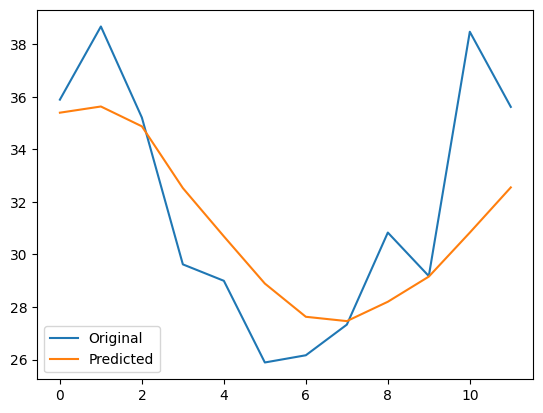

In [ ]:
prev = 12
lr = 0.029
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### LR - Resultado
A rede com taxa de aprendizado entre 0,02 e 0,04 apresentou os melhores resultados, sendo o 0,03 o melhor entre eles.

##### Função de Ativação - Camada Escondida

In [ ]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    #self.out = nn.Sigmoid() #Para o caso binário

  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

###### Sigmoid

  7%|▋         | 68/1000 [00:00<00:04, 196.09it/s]

Epoch 51/1000, Loss: 0.0376


 11%|█         | 110/1000 [00:00<00:05, 176.42it/s]

Epoch 101/1000, Loss: 0.0301


 16%|█▌        | 158/1000 [00:01<00:08, 102.72it/s]

Epoch 151/1000, Loss: 0.0230


 21%|██        | 211/1000 [00:01<00:10, 71.73it/s]

Epoch 201/1000, Loss: 0.0179


 26%|██▌       | 261/1000 [00:02<00:12, 61.15it/s]

Epoch 251/1000, Loss: 0.0152


 32%|███▏      | 318/1000 [00:03<00:06, 111.22it/s]

Epoch 301/1000, Loss: 0.0141


 37%|███▋      | 371/1000 [00:03<00:05, 105.88it/s]

Epoch 351/1000, Loss: 0.0137


 41%|████      | 408/1000 [00:04<00:05, 104.70it/s]

Epoch 401/1000, Loss: 0.0135


 46%|████▌     | 462/1000 [00:04<00:05, 92.19it/s]

Epoch 451/1000, Loss: 0.0134


 51%|█████     | 509/1000 [00:05<00:05, 96.30it/s] 

Epoch 501/1000, Loss: 0.0133


 56%|█████▋    | 565/1000 [00:05<00:04, 97.05it/s]

Epoch 551/1000, Loss: 0.0132


 61%|██████▏   | 614/1000 [00:06<00:04, 93.99it/s]

Epoch 601/1000, Loss: 0.0131


 67%|██████▋   | 671/1000 [00:06<00:02, 113.69it/s]

Epoch 651/1000, Loss: 0.0130


 72%|███████▏  | 723/1000 [00:07<00:02, 111.41it/s]

Epoch 701/1000, Loss: 0.0129


 76%|███████▌  | 759/1000 [00:07<00:01, 138.31it/s]

Epoch 751/1000, Loss: 0.0128


 81%|████████  | 810/1000 [00:07<00:01, 102.30it/s]

Epoch 801/1000, Loss: 0.0127


 86%|████████▌ | 862/1000 [00:08<00:01, 95.36it/s]

Epoch 851/1000, Loss: 0.0126


 92%|█████████▏| 915/1000 [00:08<00:00, 126.45it/s]

Epoch 901/1000, Loss: 0.0125


 98%|█████████▊| 981/1000 [00:09<00:00, 138.75it/s]

Epoch 951/1000, Loss: 0.0124


100%|██████████| 1000/1000 [00:09<00:00, 105.26it/s]


Epoch 1001/1000, Loss: 0.0123
Erro MSE = 9.239 
Erro MAE = 2.279


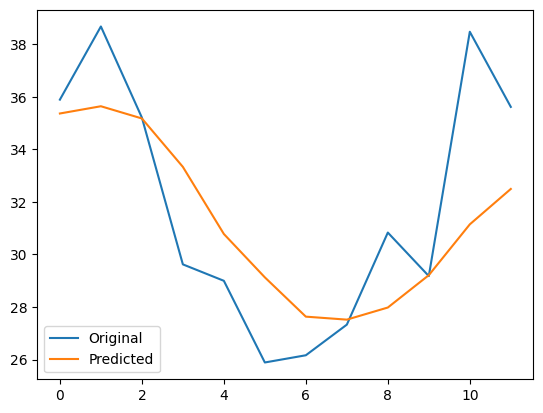

In [ ]:
prev = 12
lr = 0.03
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### ReLu

  6%|▌         | 62/1000 [00:00<00:10, 88.01it/s]

Epoch 51/1000, Loss: 0.0349


 11%|█▏        | 113/1000 [00:01<00:09, 97.42it/s] 

Epoch 101/1000, Loss: 0.0162


 16%|█▋        | 164/1000 [00:01<00:09, 91.99it/s]

Epoch 151/1000, Loss: 0.0137


 21%|██▏       | 213/1000 [00:02<00:08, 92.14it/s]

Epoch 201/1000, Loss: 0.0131


 28%|██▊       | 285/1000 [00:02<00:04, 145.97it/s]

Epoch 251/1000, Loss: 0.0127


 33%|███▎      | 330/1000 [00:02<00:03, 183.33it/s]

Epoch 301/1000, Loss: 0.0124


 37%|███▋      | 373/1000 [00:03<00:03, 198.79it/s]

Epoch 351/1000, Loss: 0.0121


 44%|████▍     | 438/1000 [00:03<00:02, 207.46it/s]

Epoch 401/1000, Loss: 0.0119


 48%|████▊     | 481/1000 [00:03<00:02, 199.89it/s]

Epoch 451/1000, Loss: 0.0117


 52%|█████▏    | 524/1000 [00:03<00:02, 205.93it/s]

Epoch 501/1000, Loss: 0.0115


 59%|█████▉    | 588/1000 [00:04<00:02, 205.77it/s]

Epoch 551/1000, Loss: 0.0114


 63%|██████▎   | 630/1000 [00:04<00:01, 191.13it/s]

Epoch 601/1000, Loss: 0.0113


 67%|██████▋   | 671/1000 [00:04<00:01, 195.68it/s]

Epoch 651/1000, Loss: 0.0112


 73%|███████▎  | 732/1000 [00:05<00:01, 184.79it/s]

Epoch 701/1000, Loss: 0.0111


 77%|███████▋  | 771/1000 [00:05<00:01, 174.61it/s]

Epoch 751/1000, Loss: 0.0110


 83%|████████▎ | 831/1000 [00:05<00:00, 232.95it/s]

Epoch 801/1000, Loss: 0.0109


 86%|████████▌ | 855/1000 [00:05<00:00, 177.31it/s]

Epoch 851/1000, Loss: 0.0108


 93%|█████████▎| 929/1000 [00:06<00:00, 159.53it/s]

Epoch 901/1000, Loss: 0.0108


 98%|█████████▊| 984/1000 [00:06<00:00, 161.76it/s]

Epoch 951/1000, Loss: 0.0107


100%|██████████| 1000/1000 [00:06<00:00, 150.67it/s]


Epoch 1001/1000, Loss: 0.0106
Erro MSE = 9.339 
Erro MAE = 2.311


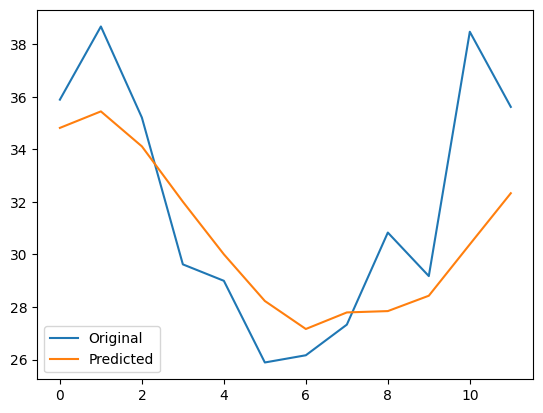

In [ ]:
prev = 12
lr = 0.02
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='relu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### Softmax


  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-146-0374f6bae0d7>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  h1 = self.ha(h)
  6%|▋         | 63/1000 [00:00<00:09, 103.44it/s]

Epoch 51/1000, Loss: 0.0475


 11%|█         | 112/1000 [00:01<00:10, 84.03it/s]

Epoch 101/1000, Loss: 0.0429


 18%|█▊        | 183/1000 [00:01<00:06, 123.97it/s]

Epoch 151/1000, Loss: 0.0370


 22%|██▎       | 225/1000 [00:02<00:04, 164.66it/s]

Epoch 201/1000, Loss: 0.0298


 28%|██▊       | 281/1000 [00:02<00:04, 174.19it/s]

Epoch 251/1000, Loss: 0.0228


 32%|███▏      | 317/1000 [00:02<00:03, 172.12it/s]

Epoch 301/1000, Loss: 0.0181


 37%|███▋      | 374/1000 [00:02<00:03, 174.19it/s]

Epoch 351/1000, Loss: 0.0160


 43%|████▎     | 431/1000 [00:03<00:03, 182.94it/s]

Epoch 401/1000, Loss: 0.0153


 47%|████▋     | 468/1000 [00:03<00:03, 173.36it/s]

Epoch 451/1000, Loss: 0.0151


 53%|█████▎    | 527/1000 [00:03<00:02, 184.28it/s]

Epoch 501/1000, Loss: 0.0149


 59%|█████▊    | 587/1000 [00:04<00:02, 190.48it/s]

Epoch 551/1000, Loss: 0.0148


 63%|██████▎   | 627/1000 [00:04<00:01, 190.28it/s]

Epoch 601/1000, Loss: 0.0146


 69%|██████▊   | 686/1000 [00:04<00:01, 177.02it/s]

Epoch 651/1000, Loss: 0.0144


 72%|███████▏  | 724/1000 [00:04<00:01, 176.74it/s]

Epoch 701/1000, Loss: 0.0142


 78%|███████▊  | 784/1000 [00:05<00:01, 179.57it/s]

Epoch 751/1000, Loss: 0.0140


 82%|████████▏ | 823/1000 [00:05<00:00, 184.03it/s]

Epoch 801/1000, Loss: 0.0138


 88%|████████▊ | 882/1000 [00:05<00:00, 189.68it/s]

Epoch 851/1000, Loss: 0.0136


 92%|█████████▏| 921/1000 [00:05<00:00, 179.49it/s]

Epoch 901/1000, Loss: 0.0134


 98%|█████████▊| 976/1000 [00:06<00:00, 169.94it/s]

Epoch 951/1000, Loss: 0.0132


100%|██████████| 1000/1000 [00:06<00:00, 155.31it/s]


Epoch 1001/1000, Loss: 0.0130
Erro MSE = 10.688 
Erro MAE = 2.583


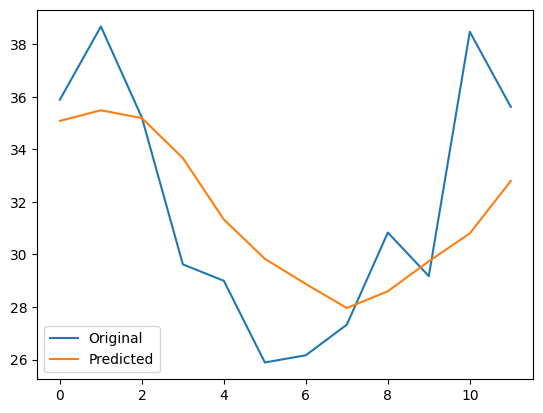

In [ ]:
prev = 12
lr = 0.03
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='softmax')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

In [ ]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    self.out = self.activations[output_activation] 
    self.out = nn.Sigmoid() #Para o caso binário

  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

##### Função de Ativação - Camada de Saída

In [ ]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    self.out = self.activations[output_activation]
    #self.out = nn.Sigmoid() #Para o caso binário

  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

###### Sigmoid

  6%|▌         | 57/1000 [00:00<00:12, 75.97it/s]

Epoch 51/1000, Loss: 0.0459


 10%|█         | 105/1000 [00:01<00:15, 57.30it/s]

Epoch 101/1000, Loss: 0.0378


 16%|█▌        | 158/1000 [00:02<00:14, 59.04it/s]

Epoch 151/1000, Loss: 0.0290


 21%|██        | 208/1000 [00:03<00:15, 51.87it/s]

Epoch 201/1000, Loss: 0.0215


 27%|██▋       | 271/1000 [00:04<00:08, 85.97it/s]

Epoch 251/1000, Loss: 0.0169


 31%|███       | 312/1000 [00:04<00:07, 86.16it/s]

Epoch 301/1000, Loss: 0.0149


 36%|███▌      | 362/1000 [00:05<00:07, 84.49it/s]

Epoch 351/1000, Loss: 0.0142


 41%|████      | 407/1000 [00:05<00:06, 84.82it/s]

Epoch 401/1000, Loss: 0.0140


 46%|████▋     | 463/1000 [00:06<00:05, 92.68it/s] 

Epoch 451/1000, Loss: 0.0139


 51%|█████     | 512/1000 [00:07<00:06, 79.34it/s]

Epoch 501/1000, Loss: 0.0138


 57%|█████▋    | 573/1000 [00:07<00:03, 112.39it/s]

Epoch 551/1000, Loss: 0.0137


 61%|██████    | 610/1000 [00:08<00:03, 99.65it/s] 

Epoch 601/1000, Loss: 0.0136


 66%|██████▋   | 663/1000 [00:08<00:03, 108.04it/s]

Epoch 651/1000, Loss: 0.0134


 71%|███████   | 712/1000 [00:08<00:02, 110.22it/s]

Epoch 701/1000, Loss: 0.0133


 76%|███████▋  | 764/1000 [00:09<00:02, 109.32it/s]

Epoch 751/1000, Loss: 0.0132


 82%|████████▏ | 817/1000 [00:09<00:01, 120.58it/s]

Epoch 801/1000, Loss: 0.0131


 86%|████████▌ | 858/1000 [00:10<00:01, 115.94it/s]

Epoch 851/1000, Loss: 0.0130


 91%|█████████▏| 914/1000 [00:10<00:00, 118.21it/s]

Epoch 901/1000, Loss: 0.0129


100%|██████████| 1000/1000 [00:11<00:00, 90.75it/s]

Epoch 951/1000, Loss: 0.0128
Epoch 1001/1000, Loss: 0.0127


Erro MSE = 9.723 
Erro MAE = 2.394


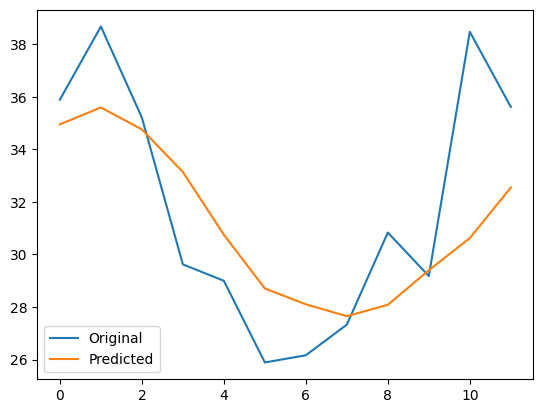

In [ ]:
prev = 12
lr = 0.03
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons,  hidden_activation='sigmoid', output_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### ReLu

  8%|▊         | 84/1000 [00:00<00:04, 199.11it/s]

Epoch 51/1000, Loss: 0.0229


 12%|█▏        | 124/1000 [00:00<00:04, 193.70it/s]

Epoch 101/1000, Loss: 0.0196


 18%|█▊        | 183/1000 [00:00<00:04, 187.96it/s]

Epoch 151/1000, Loss: 0.0191


 22%|██▏       | 224/1000 [00:01<00:04, 192.72it/s]

Epoch 201/1000, Loss: 0.0184


 28%|██▊       | 284/1000 [00:01<00:03, 189.18it/s]

Epoch 251/1000, Loss: 0.0178


 32%|███▏      | 322/1000 [00:01<00:03, 176.65it/s]

Epoch 301/1000, Loss: 0.0173


 38%|███▊      | 378/1000 [00:02<00:03, 181.26it/s]

Epoch 351/1000, Loss: 0.0168


 44%|████▍     | 441/1000 [00:02<00:02, 197.86it/s]

Epoch 401/1000, Loss: 0.0163


 48%|████▊     | 480/1000 [00:02<00:02, 181.48it/s]

Epoch 451/1000, Loss: 0.0159


 52%|█████▏    | 521/1000 [00:02<00:02, 189.97it/s]

Epoch 501/1000, Loss: 0.0155


 58%|█████▊    | 580/1000 [00:03<00:02, 179.88it/s]

Epoch 551/1000, Loss: 0.0151


 62%|██████▏   | 621/1000 [00:03<00:02, 188.51it/s]

Epoch 601/1000, Loss: 0.0147


 68%|██████▊   | 685/1000 [00:03<00:01, 194.64it/s]

Epoch 651/1000, Loss: 0.0143


 73%|███████▎  | 727/1000 [00:03<00:01, 201.74it/s]

Epoch 701/1000, Loss: 0.0140


 79%|███████▉  | 790/1000 [00:04<00:01, 197.72it/s]

Epoch 751/1000, Loss: 0.0137


 83%|████████▎ | 830/1000 [00:04<00:00, 196.27it/s]

Epoch 801/1000, Loss: 0.0133


 87%|████████▋ | 870/1000 [00:04<00:00, 190.49it/s]

Epoch 851/1000, Loss: 0.0130


 93%|█████████▎| 928/1000 [00:04<00:00, 188.06it/s]

Epoch 901/1000, Loss: 0.0127


 97%|█████████▋| 970/1000 [00:05<00:00, 194.99it/s]

Epoch 951/1000, Loss: 0.0124


100%|██████████| 1000/1000 [00:05<00:00, 189.18it/s]


Epoch 1001/1000, Loss: 0.0122
Erro MSE = 8.054 
Erro MAE = 2.173


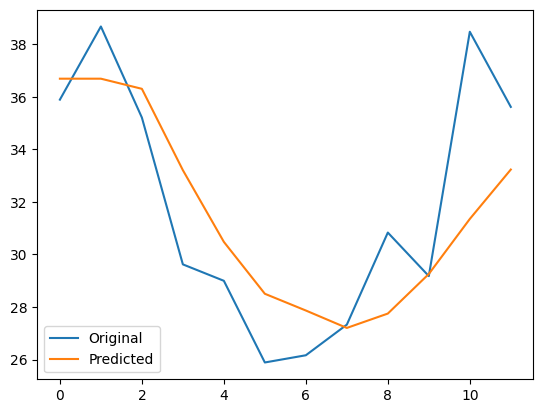

In [ ]:
prev = 12
lr = 0.03
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='relu', output_activation='relu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

###### Softmax


  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-156-d7c1ca2ab53e>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  h1 = self.ha(h)
  7%|▋         | 68/1000 [00:00<00:08, 108.07it/s]

Epoch 51/1000, Loss: 0.0411


 12%|█▏        | 116/1000 [00:01<00:07, 115.68it/s]

Epoch 101/1000, Loss: 0.0333


 16%|█▋        | 164/1000 [00:01<00:07, 109.54it/s]

Epoch 151/1000, Loss: 0.0244


 21%|██▏       | 213/1000 [00:01<00:06, 121.32it/s]

Epoch 201/1000, Loss: 0.0174


 26%|██▌       | 262/1000 [00:02<00:08, 91.80it/s]

Epoch 251/1000, Loss: 0.0143


 31%|███▏      | 313/1000 [00:03<00:07, 90.26it/s]

Epoch 301/1000, Loss: 0.0135


 36%|███▋      | 365/1000 [00:03<00:05, 118.28it/s]

Epoch 351/1000, Loss: 0.0134


 42%|████▏     | 417/1000 [00:03<00:05, 116.33it/s]

Epoch 401/1000, Loss: 0.0134


 46%|████▌     | 461/1000 [00:04<00:06, 89.15it/s]

Epoch 451/1000, Loss: 0.0133


 51%|█████     | 509/1000 [00:04<00:04, 108.99it/s]

Epoch 501/1000, Loss: 0.0132


 56%|█████▌    | 560/1000 [00:05<00:05, 74.79it/s]

Epoch 551/1000, Loss: 0.0131


 61%|██████    | 607/1000 [00:06<00:06, 64.01it/s]

Epoch 601/1000, Loss: 0.0130


 66%|██████▌   | 657/1000 [00:07<00:06, 55.30it/s]

Epoch 651/1000, Loss: 0.0128


 71%|███████   | 711/1000 [00:07<00:04, 67.62it/s]

Epoch 701/1000, Loss: 0.0127


 76%|███████▌  | 757/1000 [00:08<00:02, 89.63it/s] 

Epoch 751/1000, Loss: 0.0126


 81%|████████  | 812/1000 [00:08<00:01, 100.05it/s]

Epoch 801/1000, Loss: 0.0125


 86%|████████▋ | 865/1000 [00:09<00:01, 95.35it/s]

Epoch 851/1000, Loss: 0.0124


 91%|█████████ | 910/1000 [00:09<00:00, 99.23it/s]

Epoch 901/1000, Loss: 0.0123


 97%|█████████▋| 968/1000 [00:10<00:00, 115.11it/s]

Epoch 951/1000, Loss: 0.0122


100%|██████████| 1000/1000 [00:10<00:00, 93.37it/s]


Epoch 1001/1000, Loss: 0.0121
Erro MSE = 9.223 
Erro MAE = 2.377


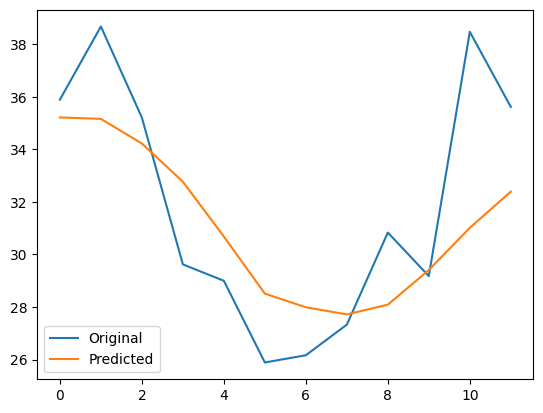

In [ ]:
prev = 12
lr = 0.03
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='softmax', output_activation='softmax')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='numeric')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### Função de Ativação
A combinação de função de ativação da camada escondidade && saida == relu apresentou os melhores resultados.

#### 5. Modifique a função de previsão multi-step para permitir a codificação binária da variável mês. Em seguida, treine um modelo MLP usando a codificação binária para a variável exógena e faça a previsão multi-step e analise o resultado. 

OBS: Para este item, basta alterar a atualização da variável exógena na condição desejada (no caso, cod = 'binary')

In [ ]:
'''
na funcao def multi_step(model, X_test, cod='numeric'):
 mudar para binary e adaptar a divisao dos meses
'''

"\nna funcao def multi_step(model, X_test, cod='numeric'):\n mudar para binary e adaptar a divisao dos meses\n"

In [ ]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    self.out = self.activations[output_activation]
    self.out = nn.Sigmoid() #Para o caso binário

  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

In [ ]:
def multi_step(model, X_test, cod='binary'):
  y_result = []
  X_t = np.copy(X_test[0])
  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())
      
      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12
        
        #Alterando a variável mês
        X_t[0] = tmp/12
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

        
      elif cod == 'binary':
        #tem como representar 12 meses/12 digítos com 4 casas (2^4 = 16)
        tmp = int(8*X_t[0] + 4*X_t[1] + 2*X_t[2] + 1*X_t[3] + 1) % 12

        binary_rep = np.binary_repr(tmp, width=4)
        X_t[:4] = np.array([int(v) for v in binary_rep])
        X_t[4:X_t.shape[0]-1] = X_t[5:]


      else:
        print('Erro de codificação.')
        break
      

      X_t[-1] = y_hat
      
      y_result.append(y_hat[0].detach().numpy())


  return np.array(y_result)

  6%|▋         | 64/1000 [00:00<00:12, 77.80it/s]

Epoch 51/1000, Loss: 0.0429


 11%|█         | 112/1000 [00:01<00:12, 69.59it/s]

Epoch 101/1000, Loss: 0.0322


 16%|█▌        | 161/1000 [00:02<00:15, 55.39it/s]

Epoch 151/1000, Loss: 0.0229


 22%|██▏       | 219/1000 [00:03<00:08, 96.76it/s]

Epoch 201/1000, Loss: 0.0165


 26%|██▋       | 265/1000 [00:03<00:07, 98.24it/s] 

Epoch 251/1000, Loss: 0.0130


 31%|███       | 309/1000 [00:04<00:07, 87.61it/s]

Epoch 301/1000, Loss: 0.0115


 36%|███▌      | 362/1000 [00:04<00:07, 88.96it/s]

Epoch 351/1000, Loss: 0.0108


 41%|████▏     | 413/1000 [00:05<00:06, 91.49it/s]

Epoch 401/1000, Loss: 0.0105


 46%|████▌     | 461/1000 [00:05<00:06, 84.06it/s]

Epoch 451/1000, Loss: 0.0103


 51%|█████     | 508/1000 [00:06<00:04, 103.73it/s]

Epoch 501/1000, Loss: 0.0102


 57%|█████▋    | 567/1000 [00:06<00:04, 107.81it/s]

Epoch 551/1000, Loss: 0.0101


 62%|██████▏   | 616/1000 [00:07<00:03, 110.69it/s]

Epoch 601/1000, Loss: 0.0100


 66%|██████▌   | 656/1000 [00:07<00:03, 94.07it/s] 

Epoch 651/1000, Loss: 0.0099


 72%|███████▏  | 721/1000 [00:08<00:02, 117.15it/s]

Epoch 701/1000, Loss: 0.0098


 78%|███████▊  | 782/1000 [00:08<00:01, 138.76it/s]

Epoch 751/1000, Loss: 0.0097


 81%|████████▏ | 814/1000 [00:09<00:01, 118.58it/s]

Epoch 801/1000, Loss: 0.0096


 86%|████████▌ | 860/1000 [00:09<00:01, 94.66it/s]

Epoch 851/1000, Loss: 0.0095


 91%|█████████▏| 913/1000 [00:10<00:00, 92.75it/s]

Epoch 901/1000, Loss: 0.0095


 96%|█████████▌| 961/1000 [00:10<00:00, 86.27it/s]

Epoch 951/1000, Loss: 0.0094


100%|██████████| 1000/1000 [00:11<00:00, 89.27it/s]


Epoch 1001/1000, Loss: 0.0093
Erro MSE = 8.132 
Erro MAE = 2.207


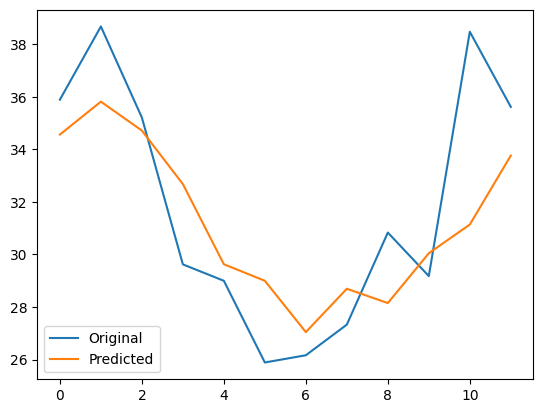

In [ ]:
prev = 12
lr = 0.03
epochs = 1000
n_output = 1
hidden_neurons = 6
batch_size = 32
lag=12

train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev, normalize=True, category='binary')

train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]

model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, output_activation='sigmoid', hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_result = multi_step(model, X_test, cod='binary')

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### Resposta

De todos os testes realizados, esse foi o que apresentou os melhores resultados. Vale ressaltar que utilizei os melhores parâmetros analisados na questão anterior, porém permaneço com dúvida em relação a escolha das funções de ativação na camada escondida e na camada de saída.